Training configurations:   0%|          | 0/3 [00:00<?, ?it/s]

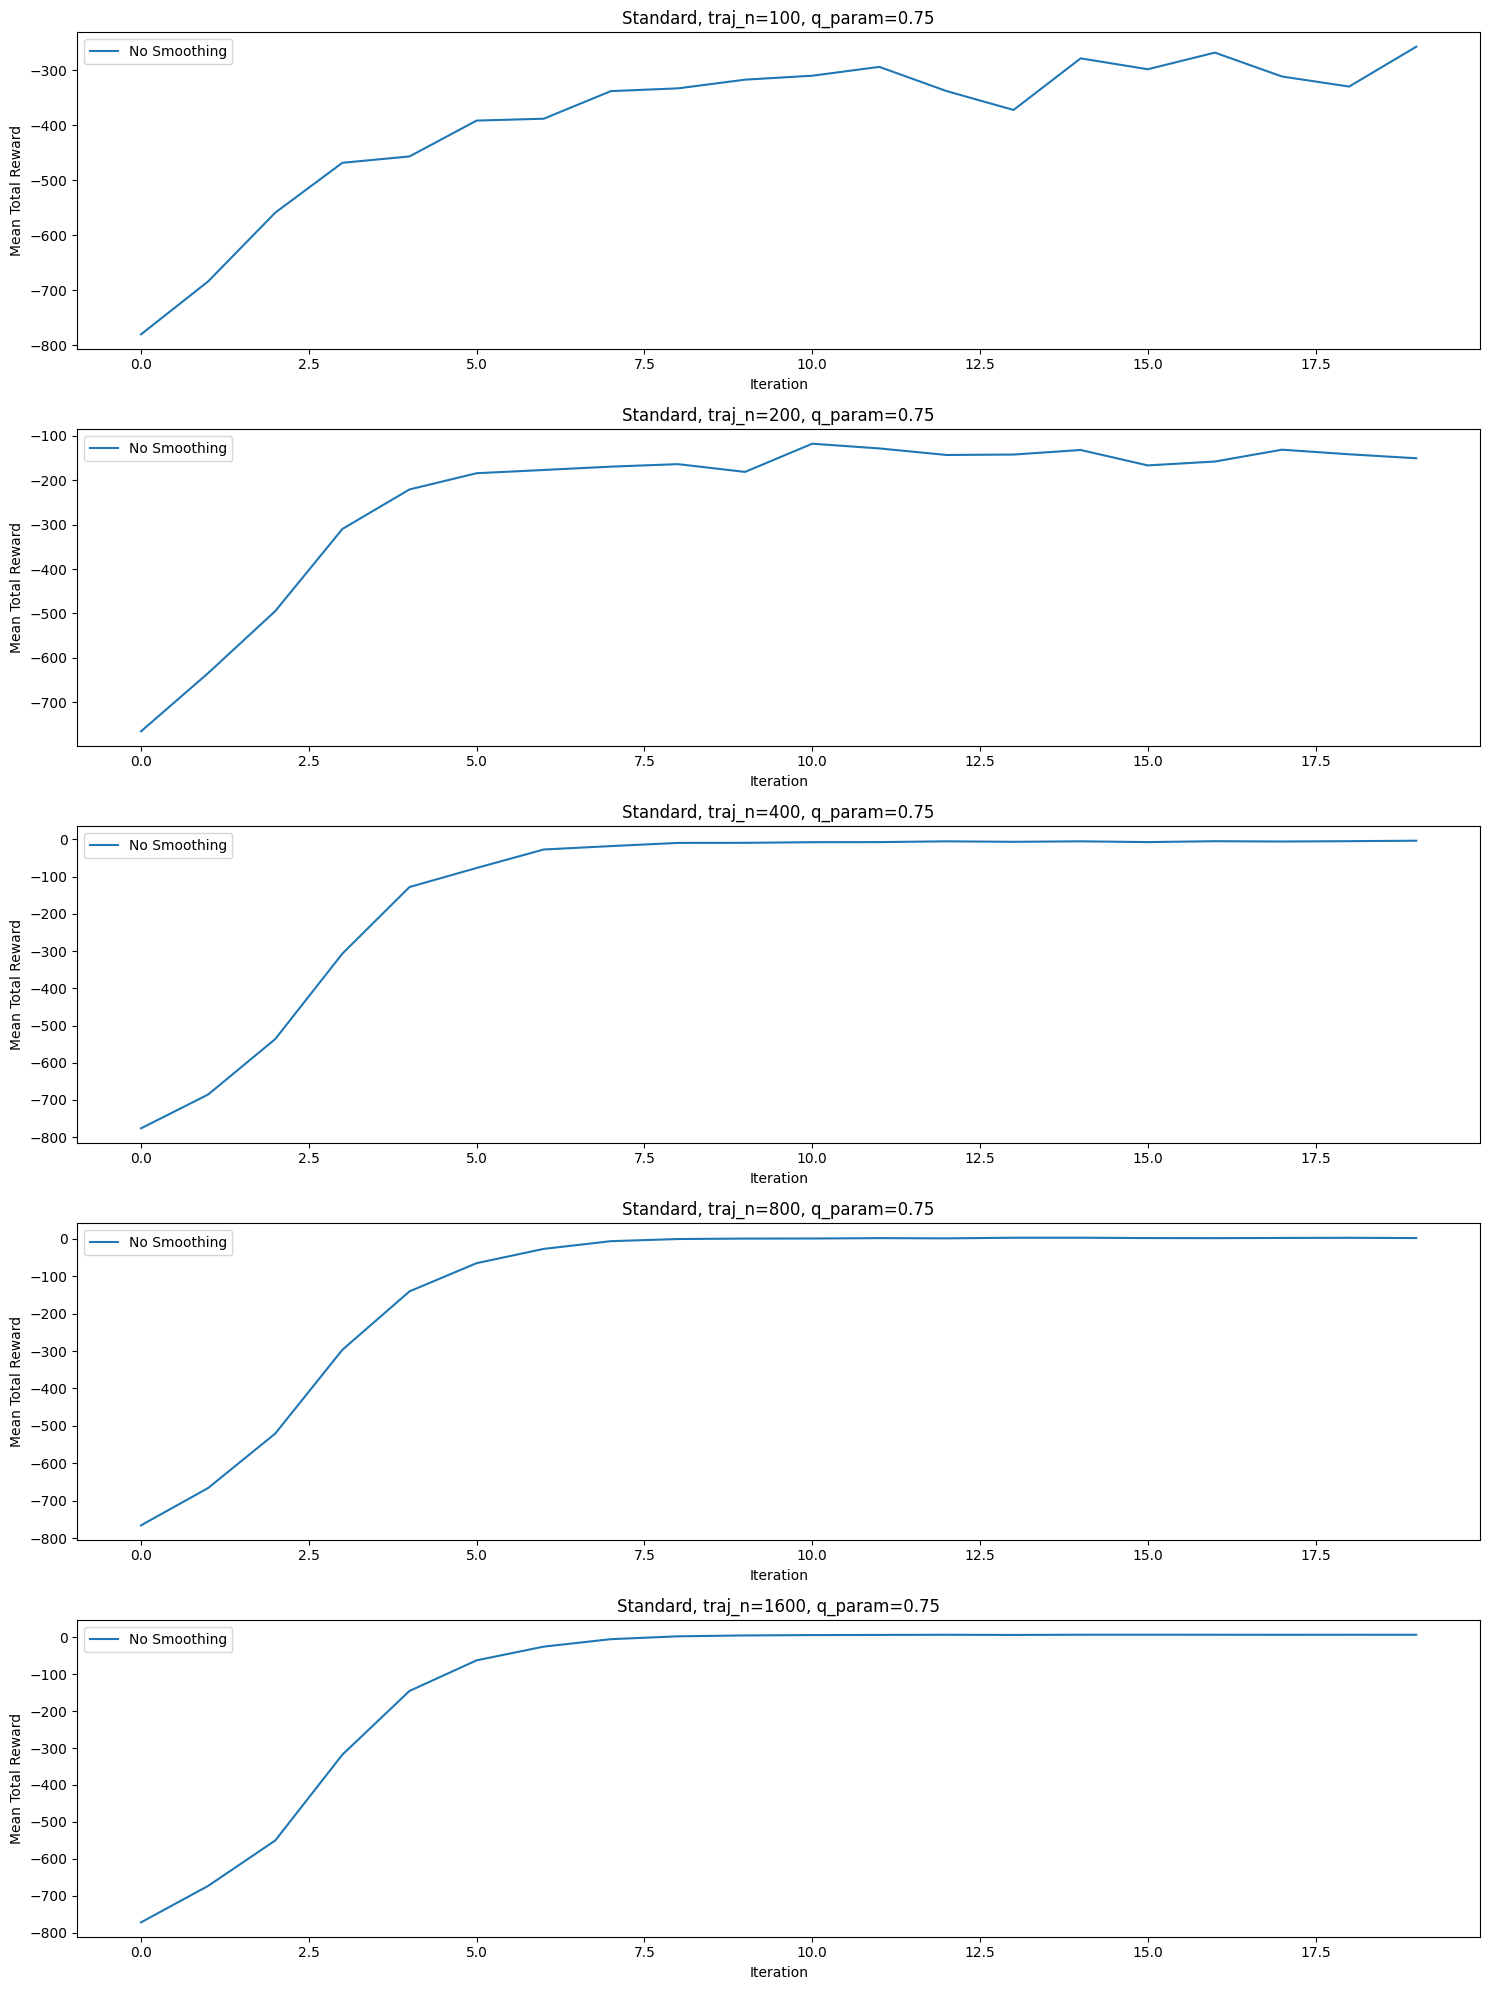

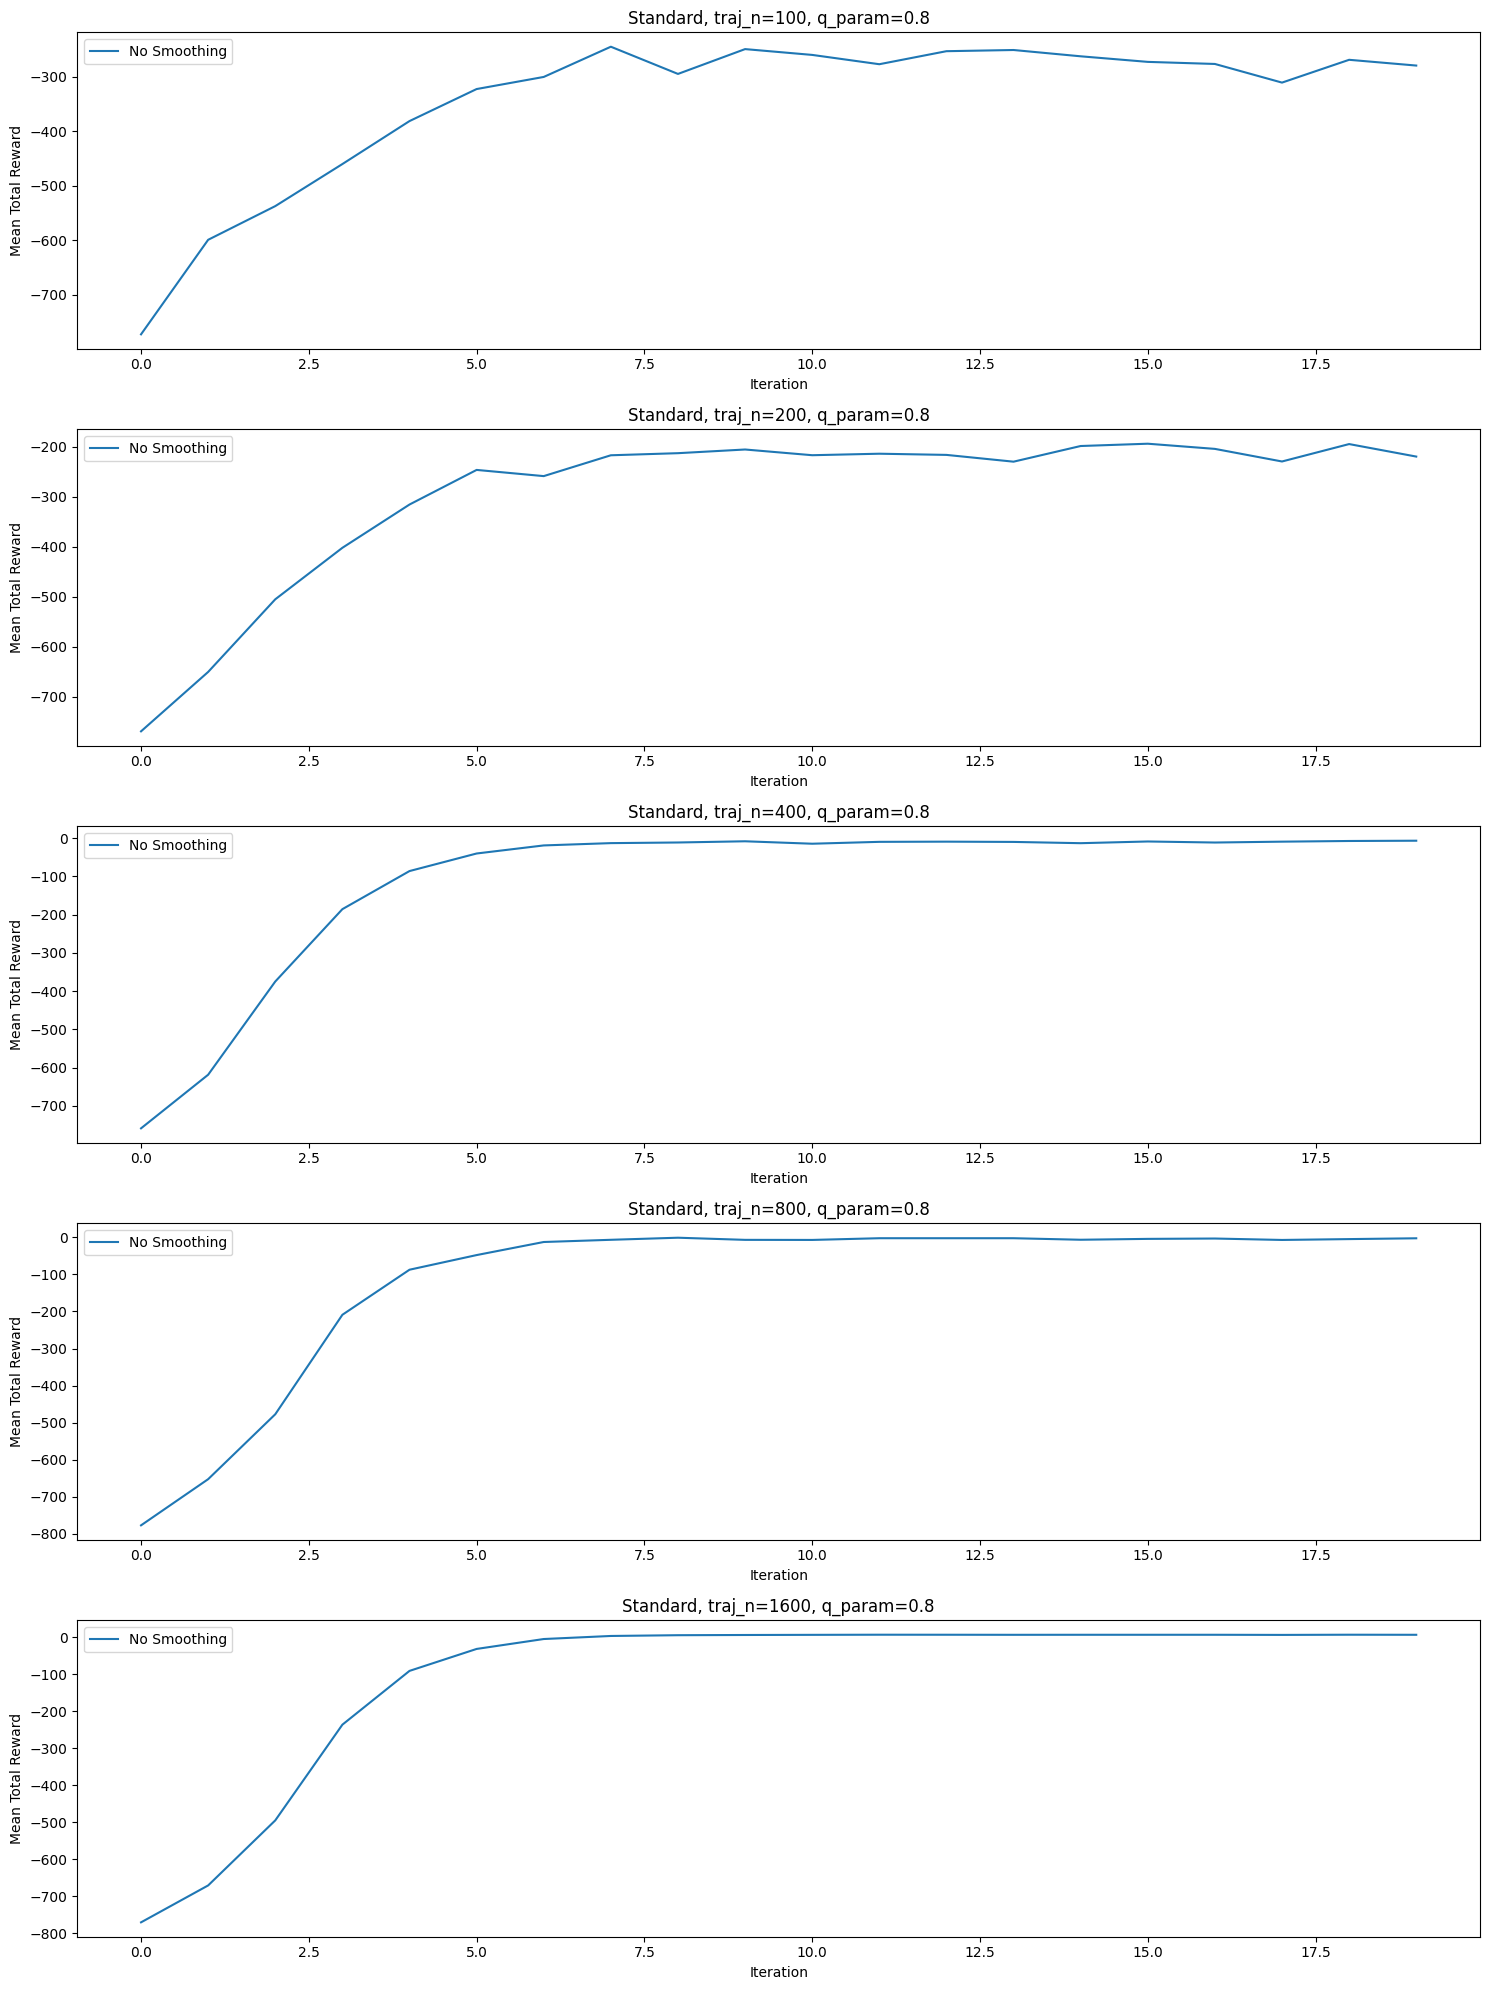

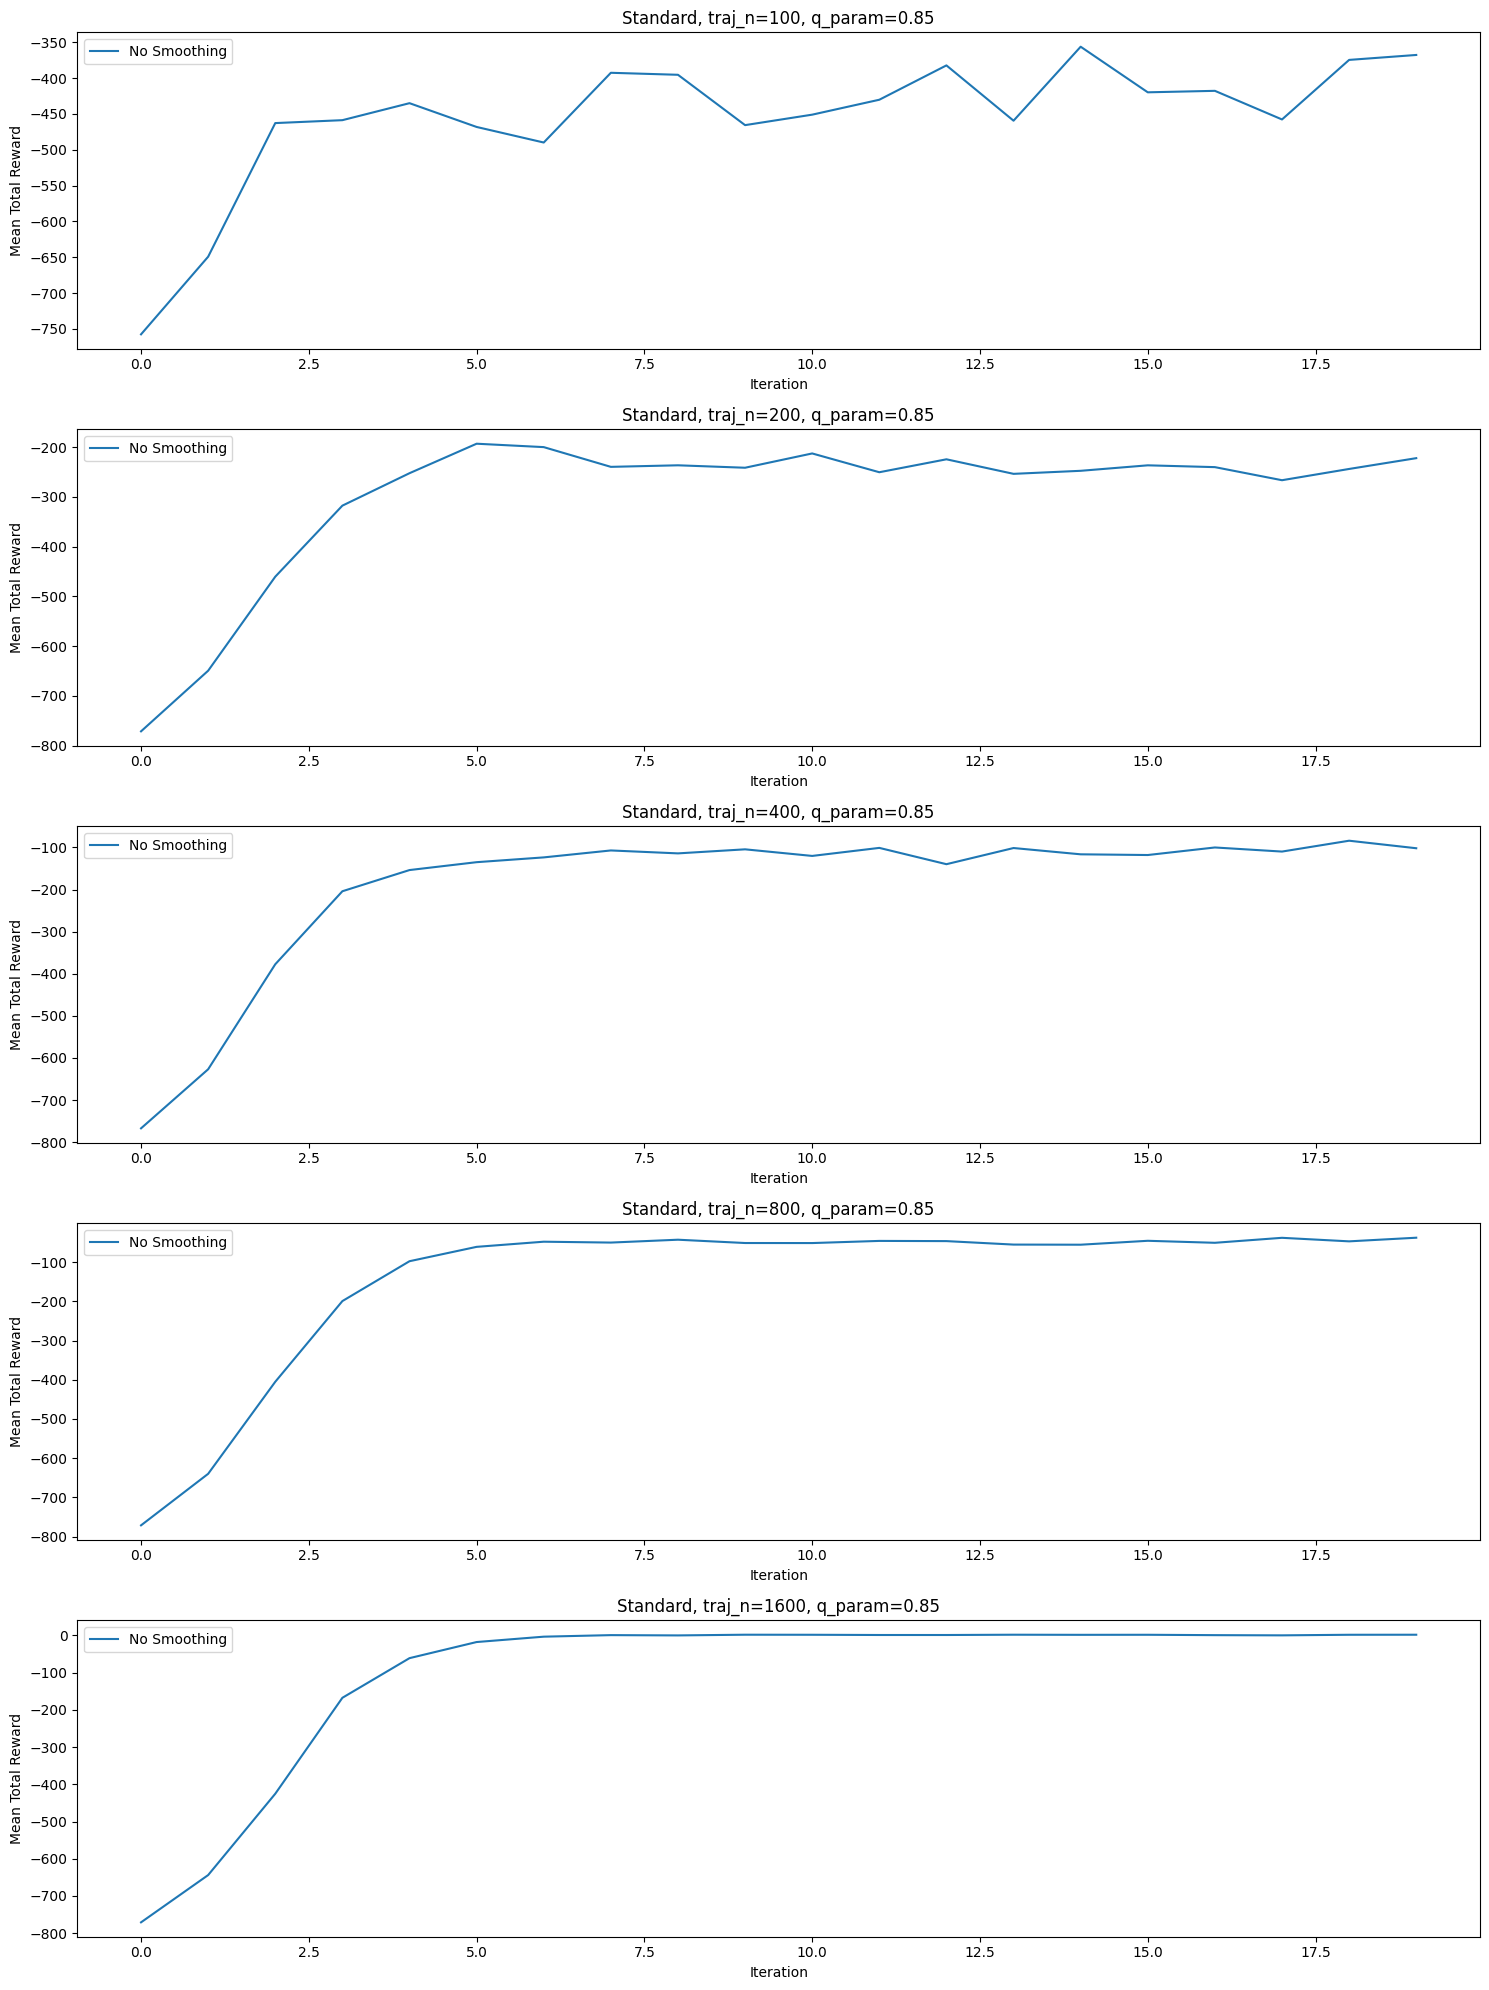

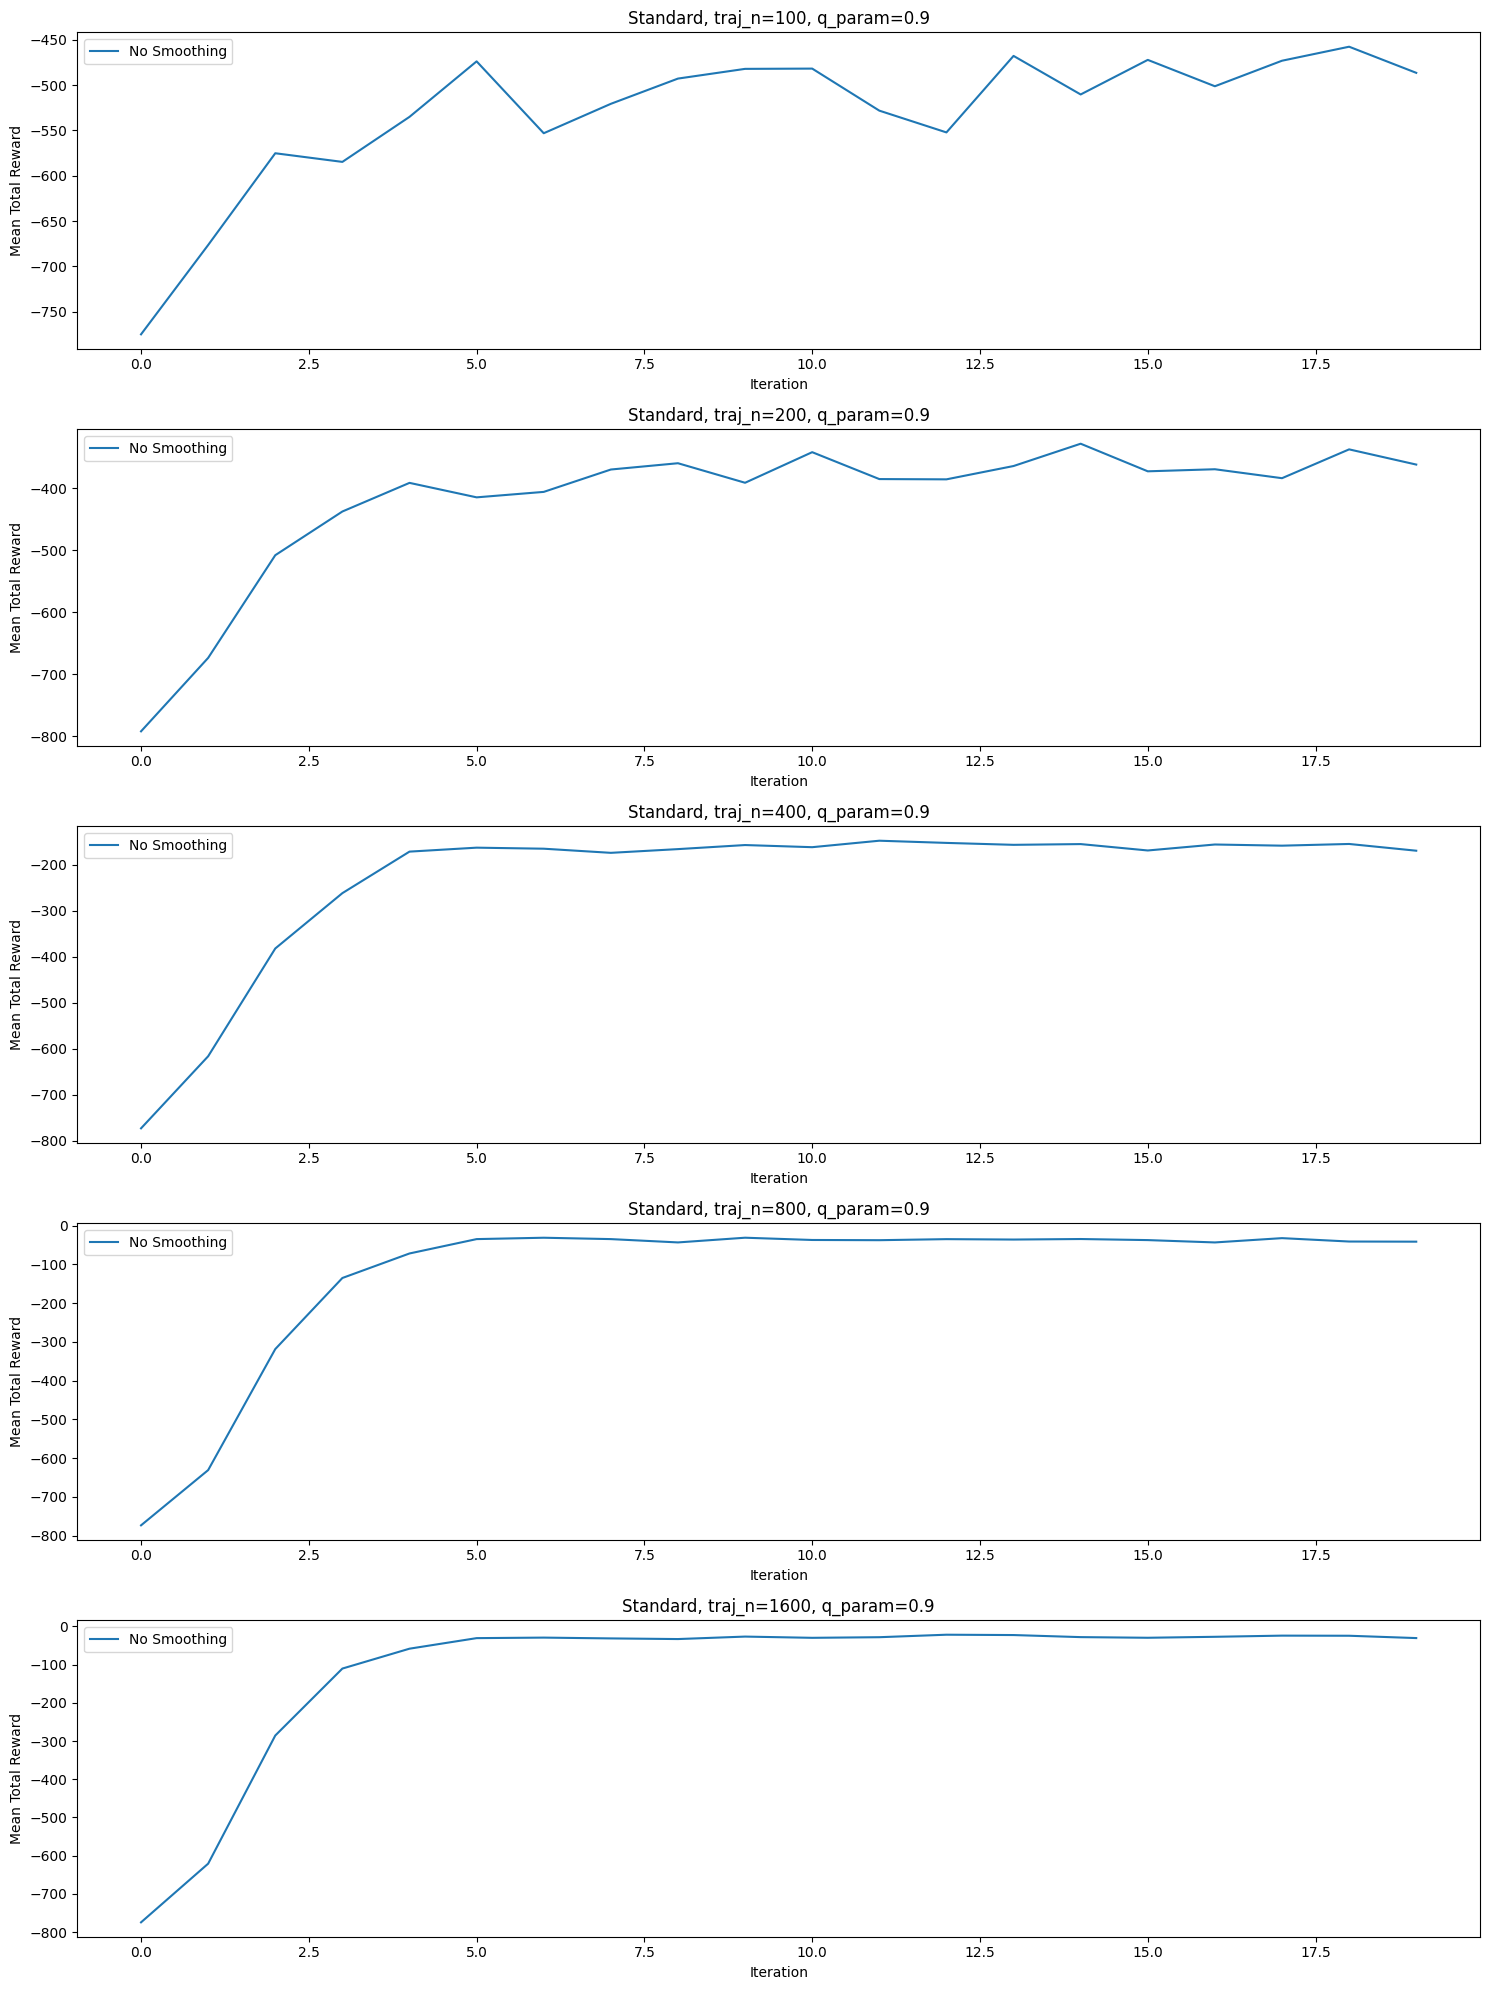

Training configurations:  33%|███▎      | 1/3 [03:37<07:14, 217.46s/it]

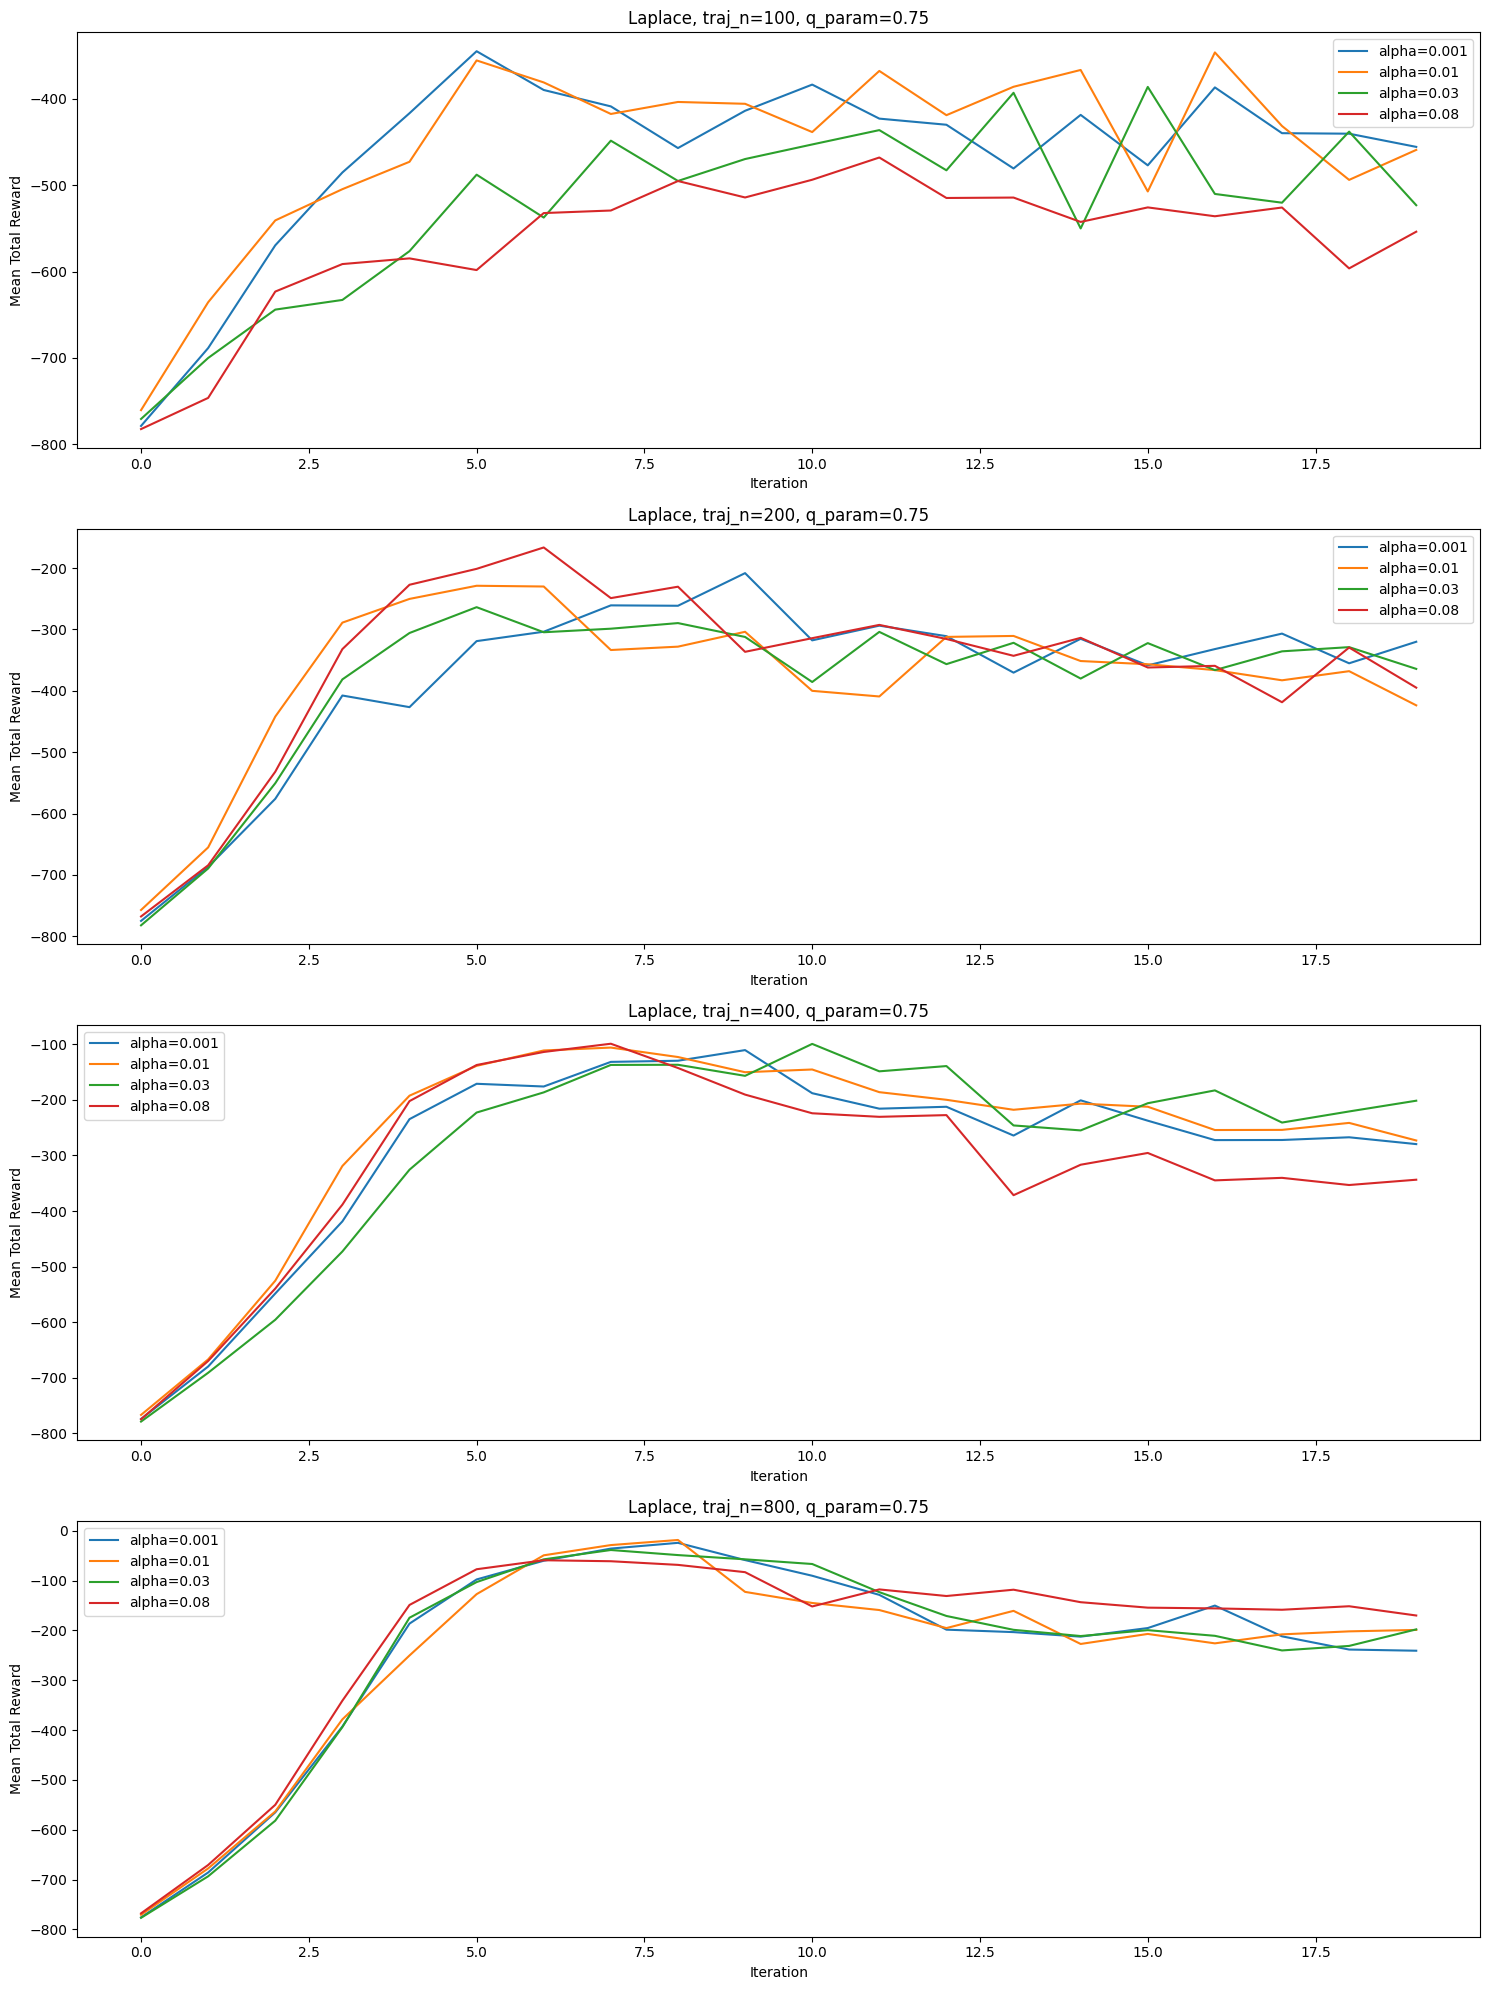

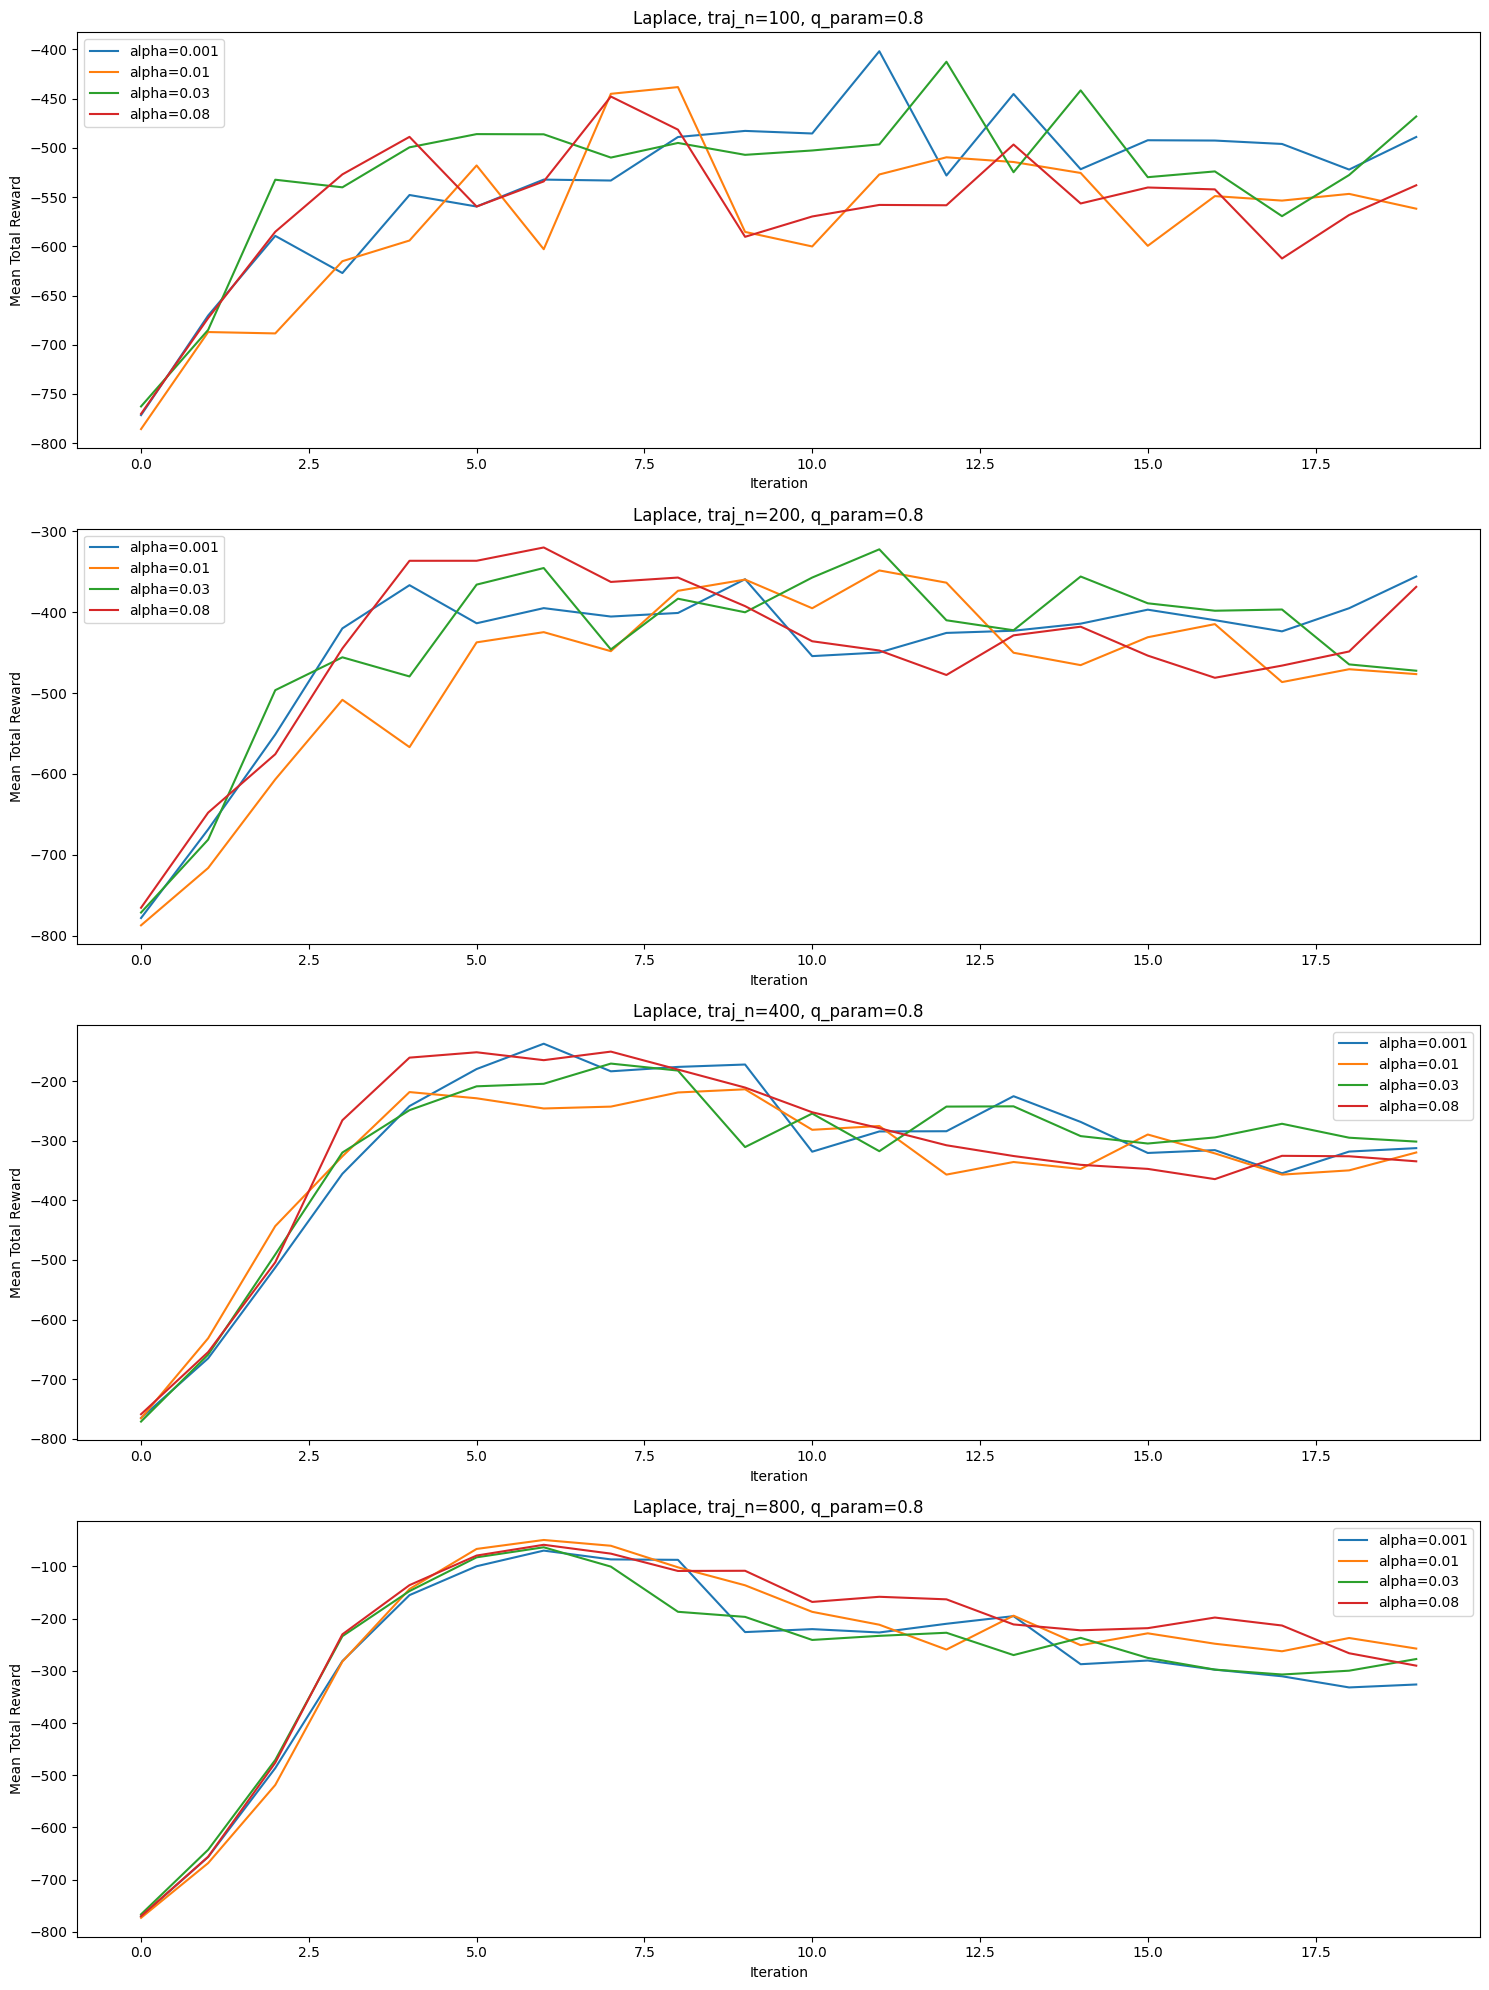

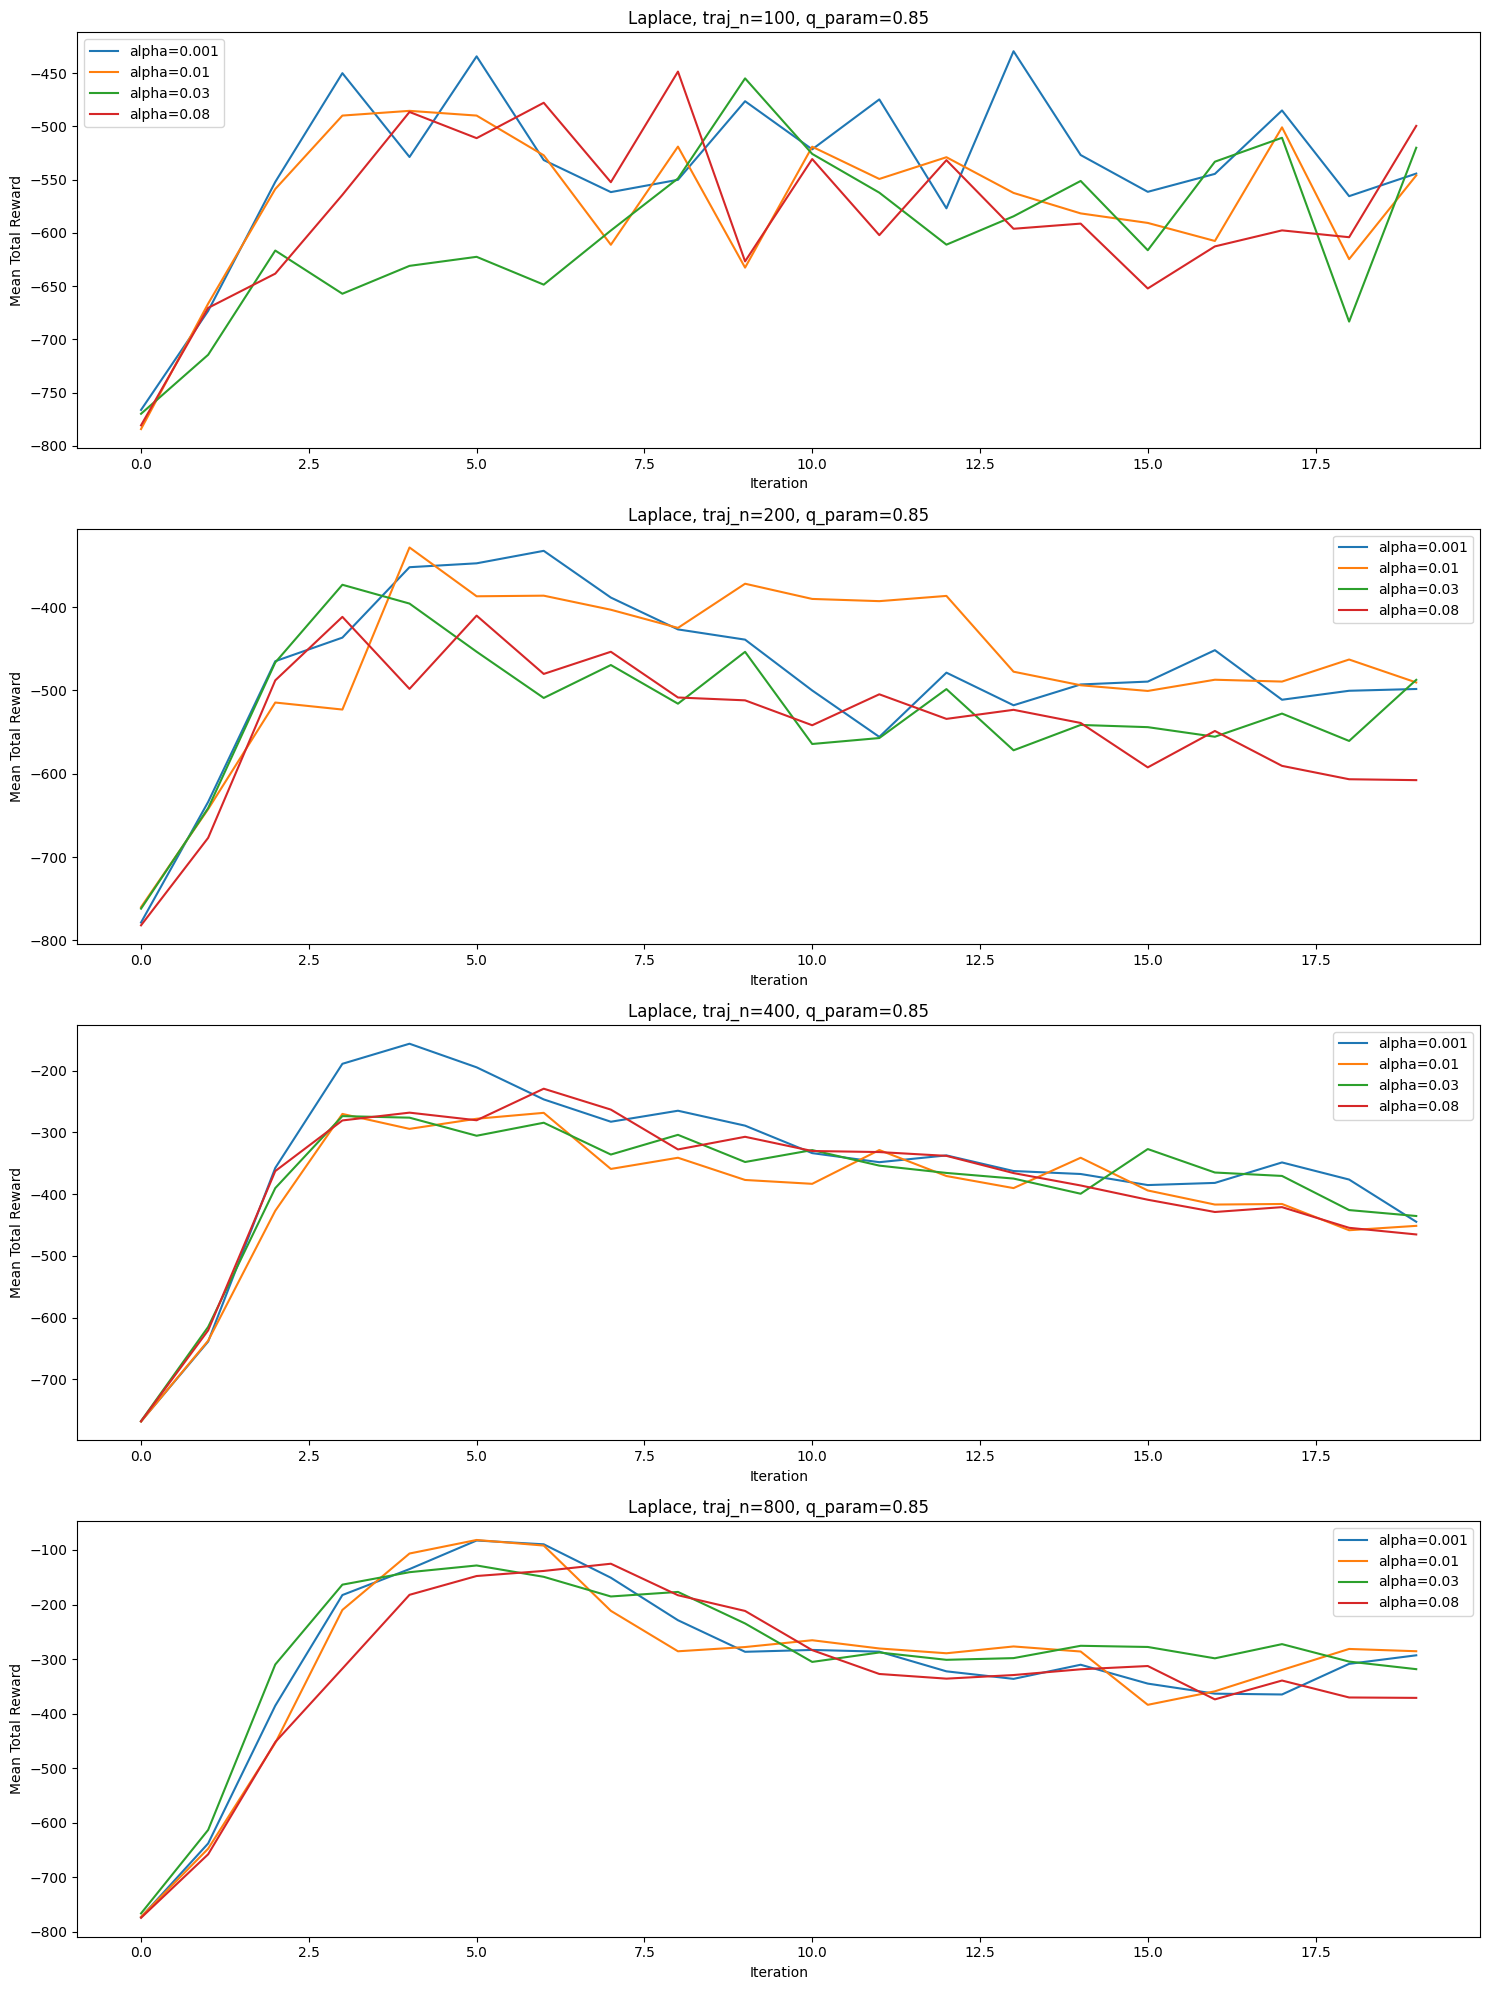

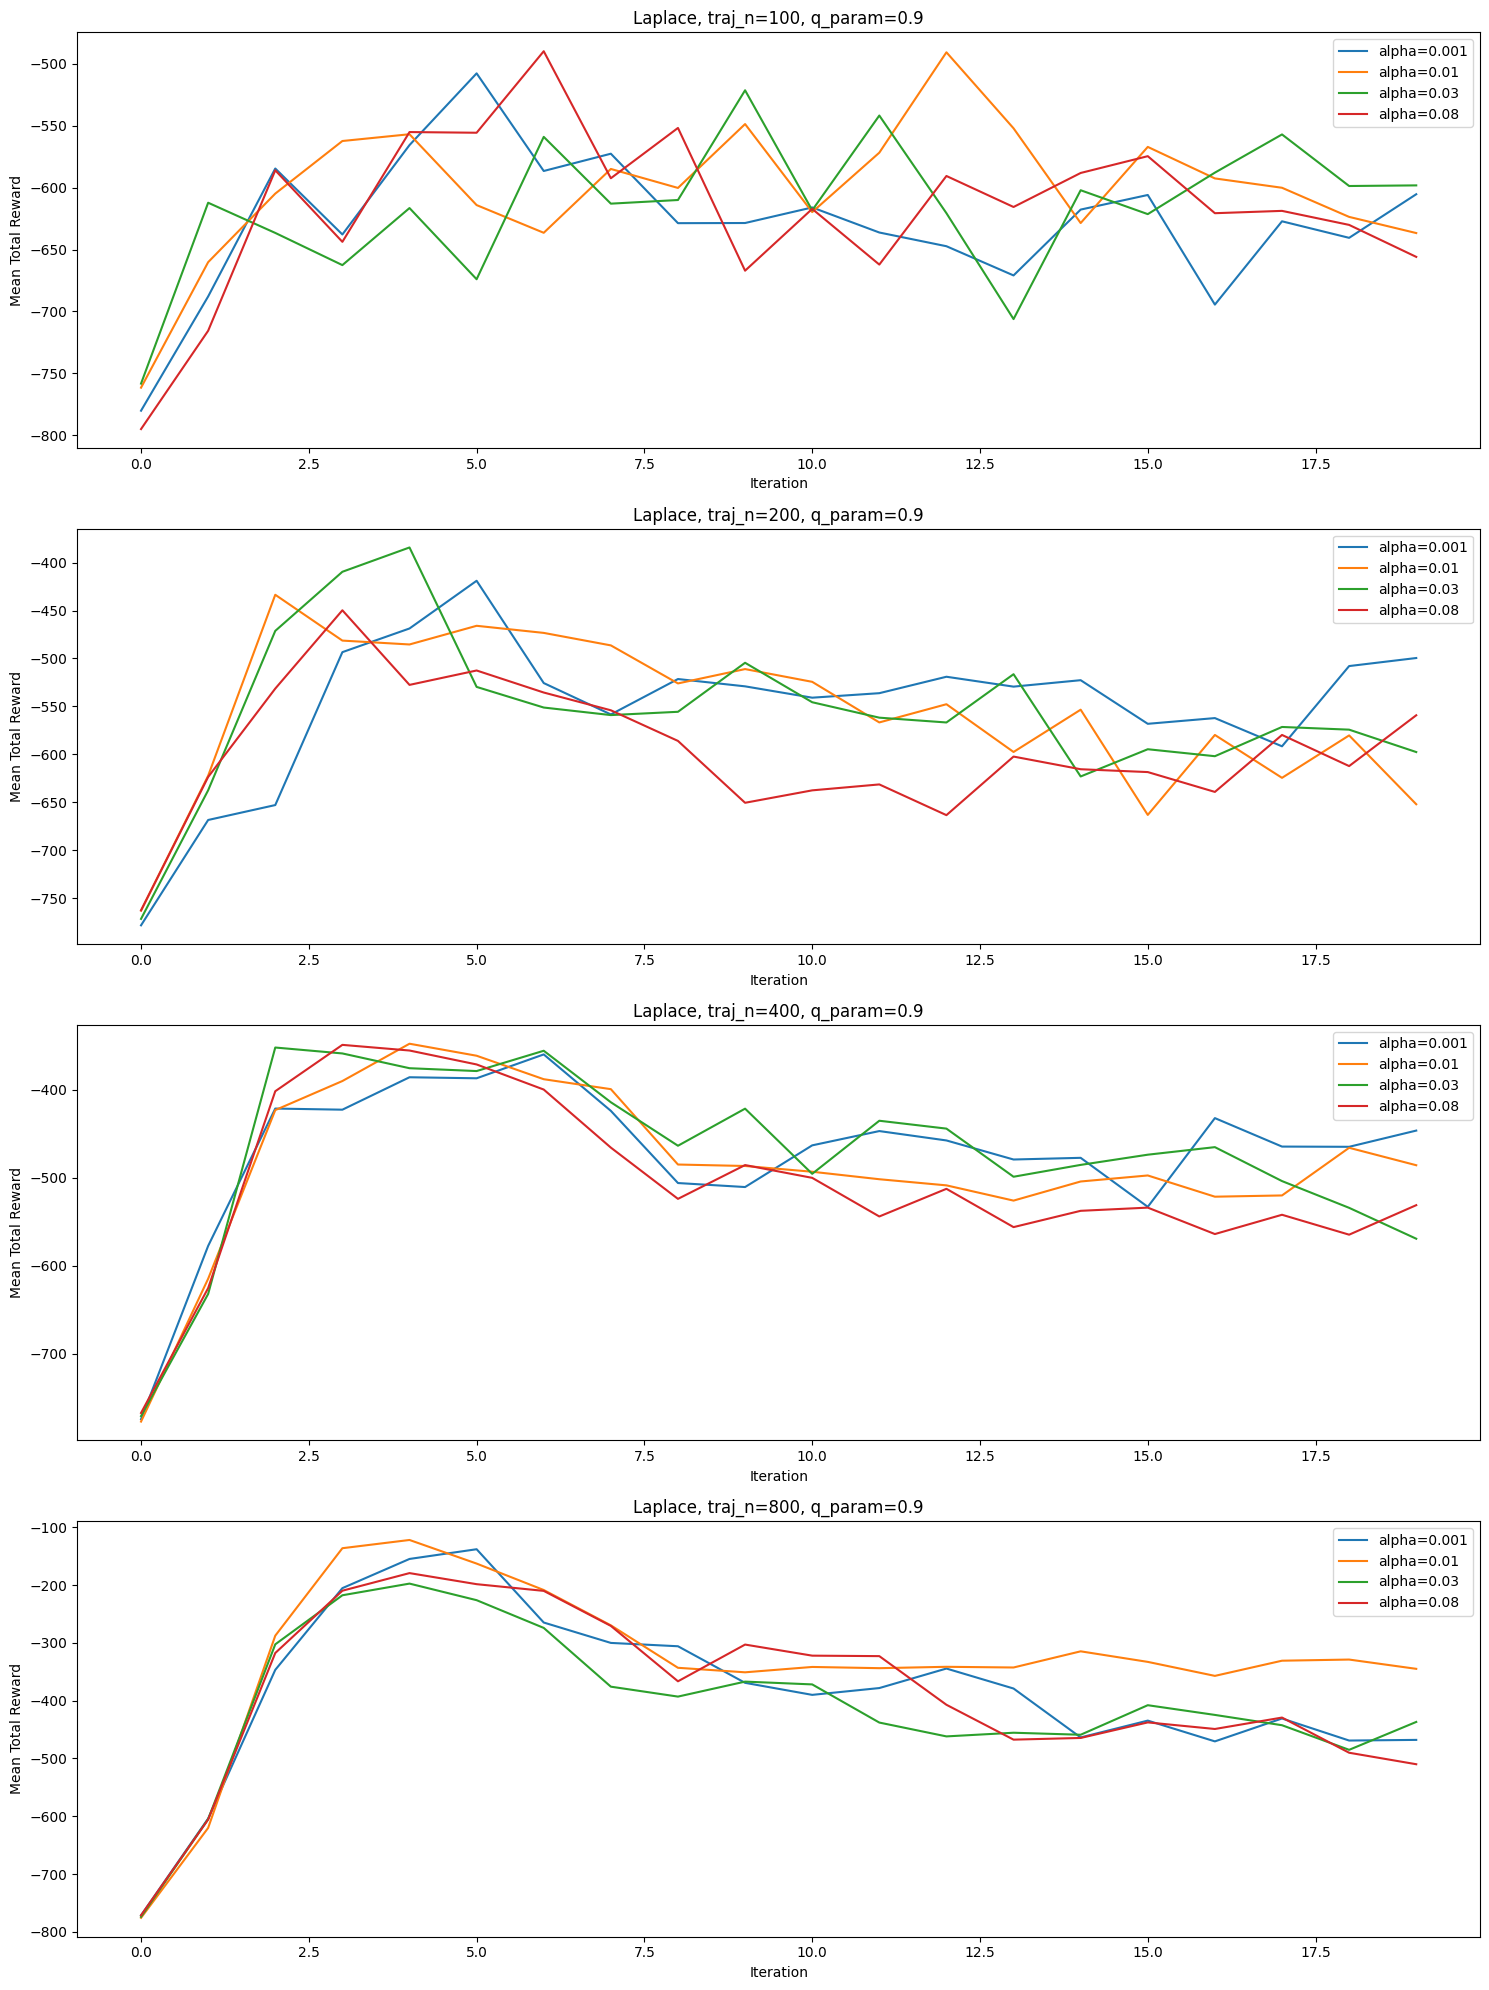

Training configurations:  67%|██████▋   | 2/3 [16:12<08:53, 533.85s/it]

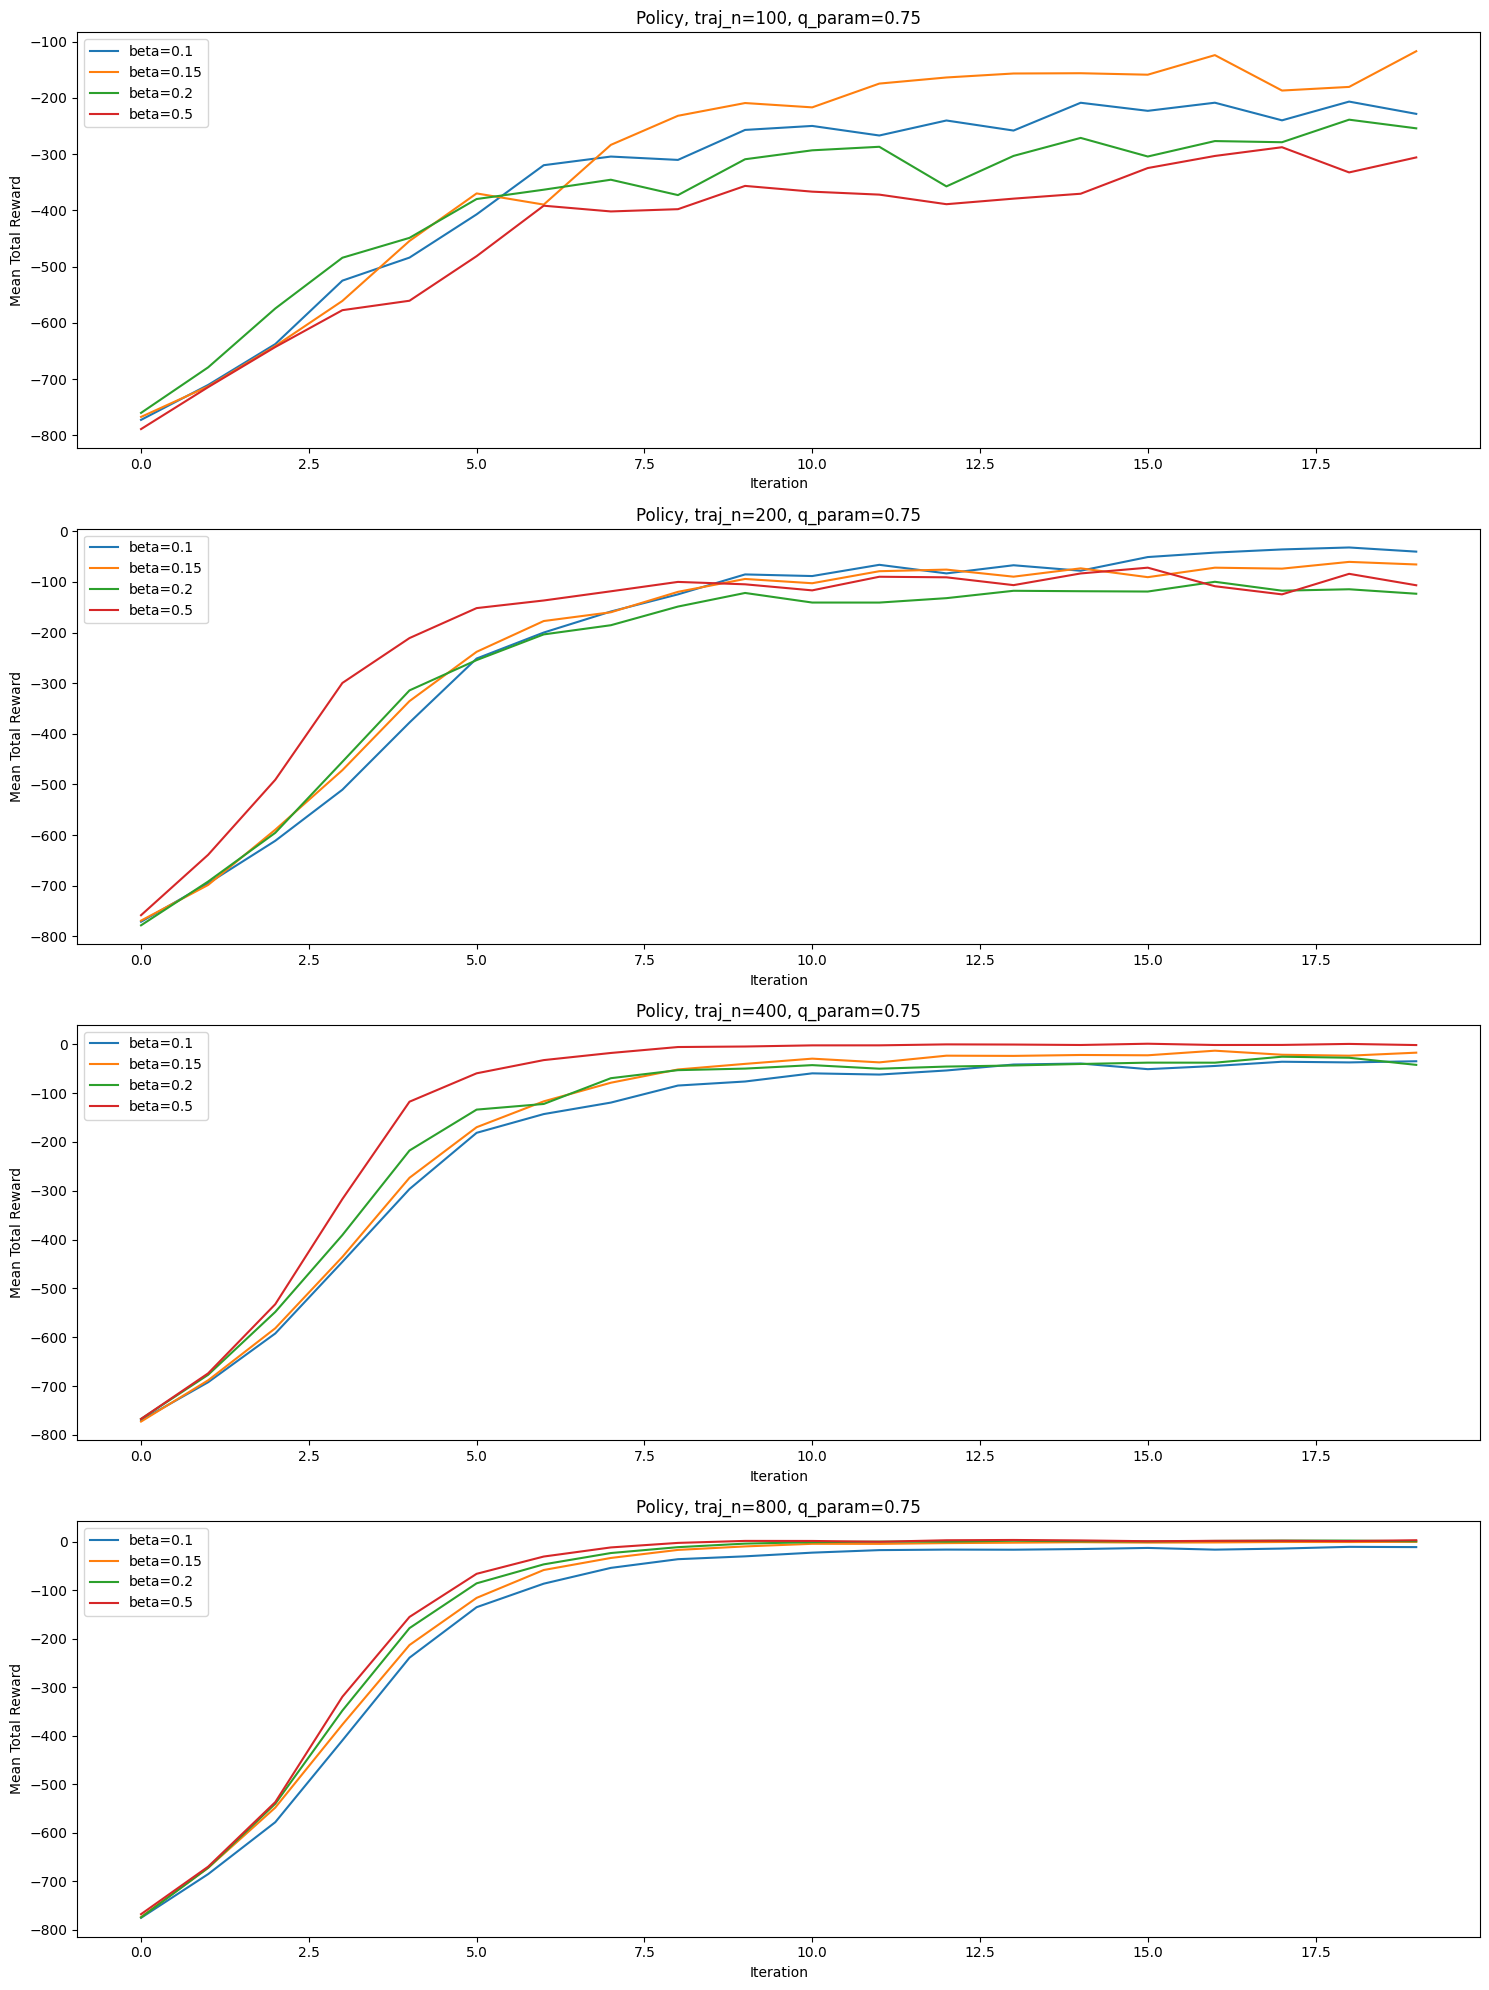

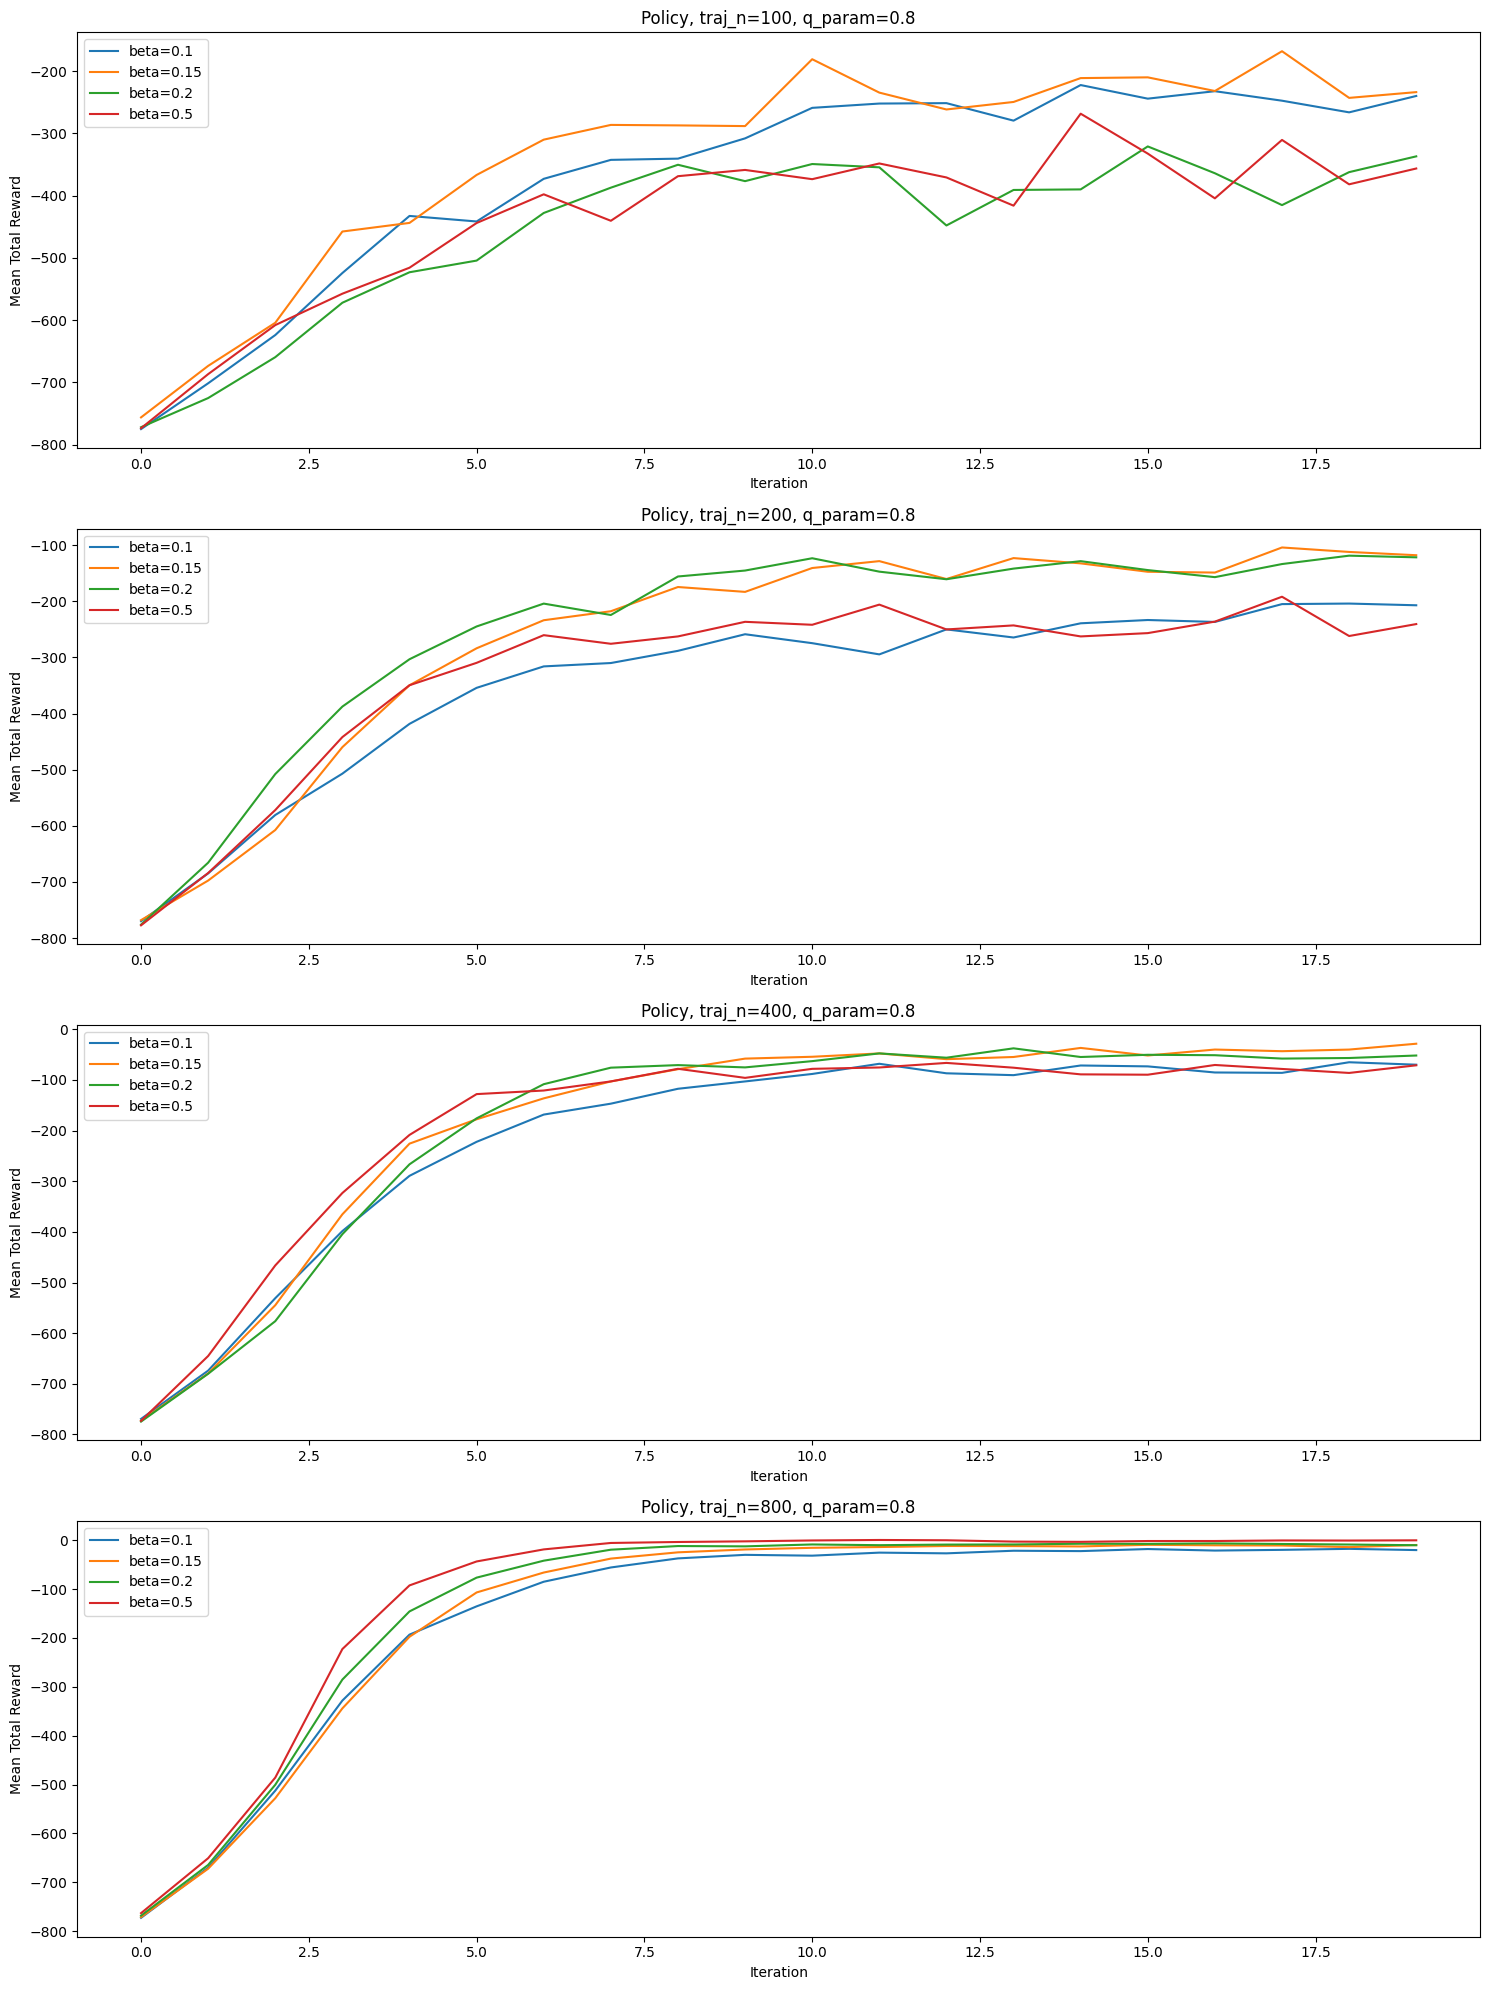

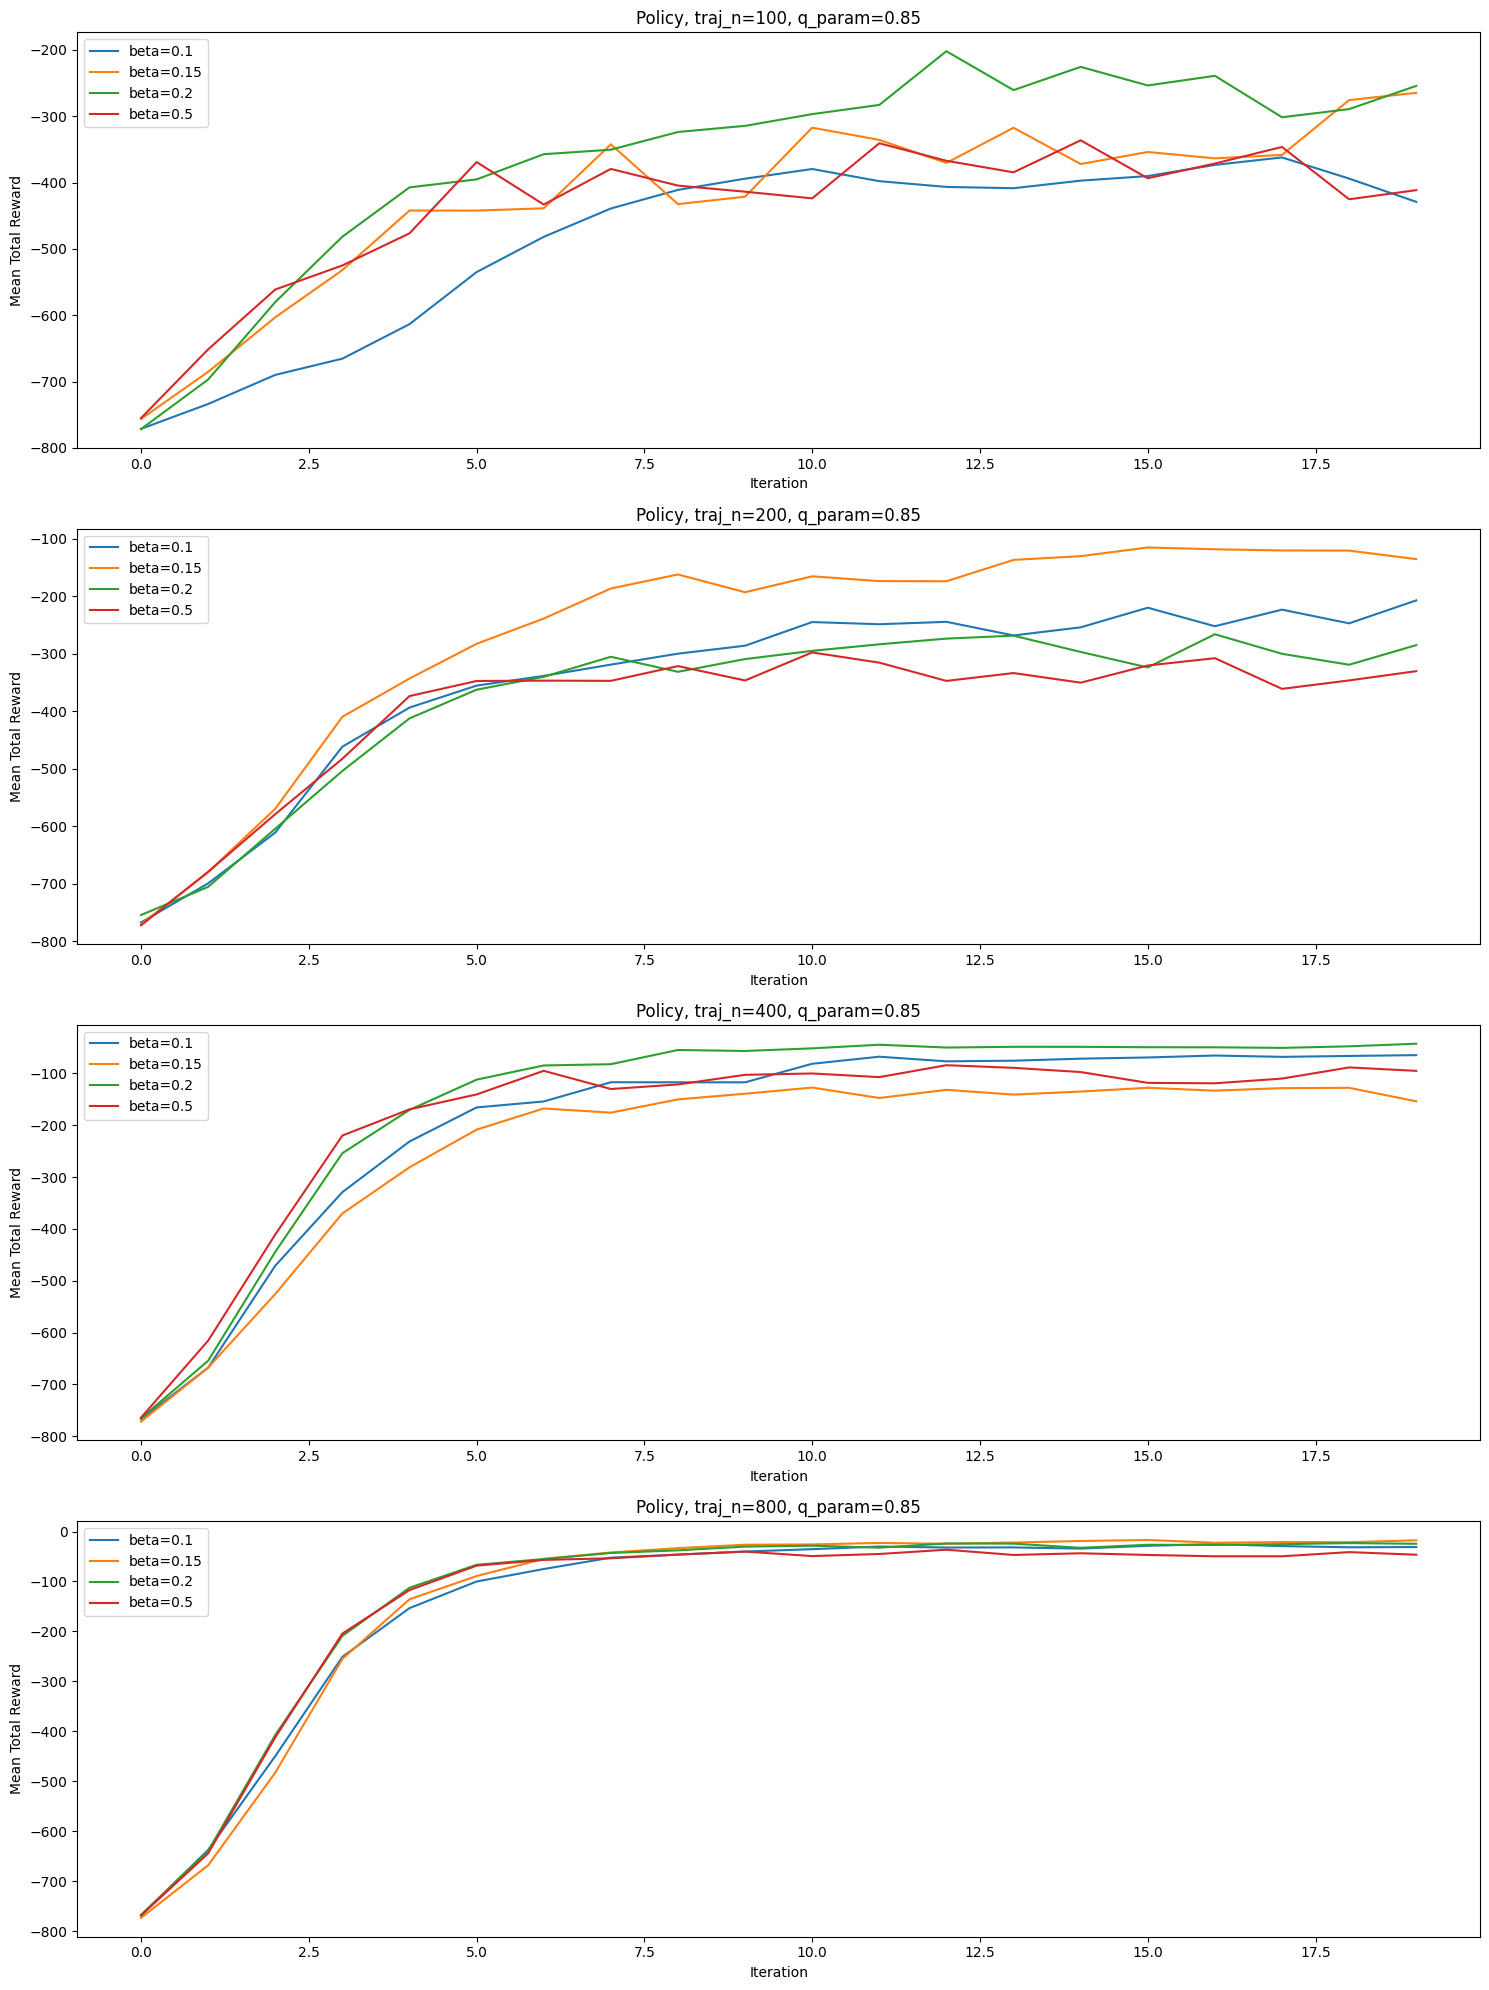

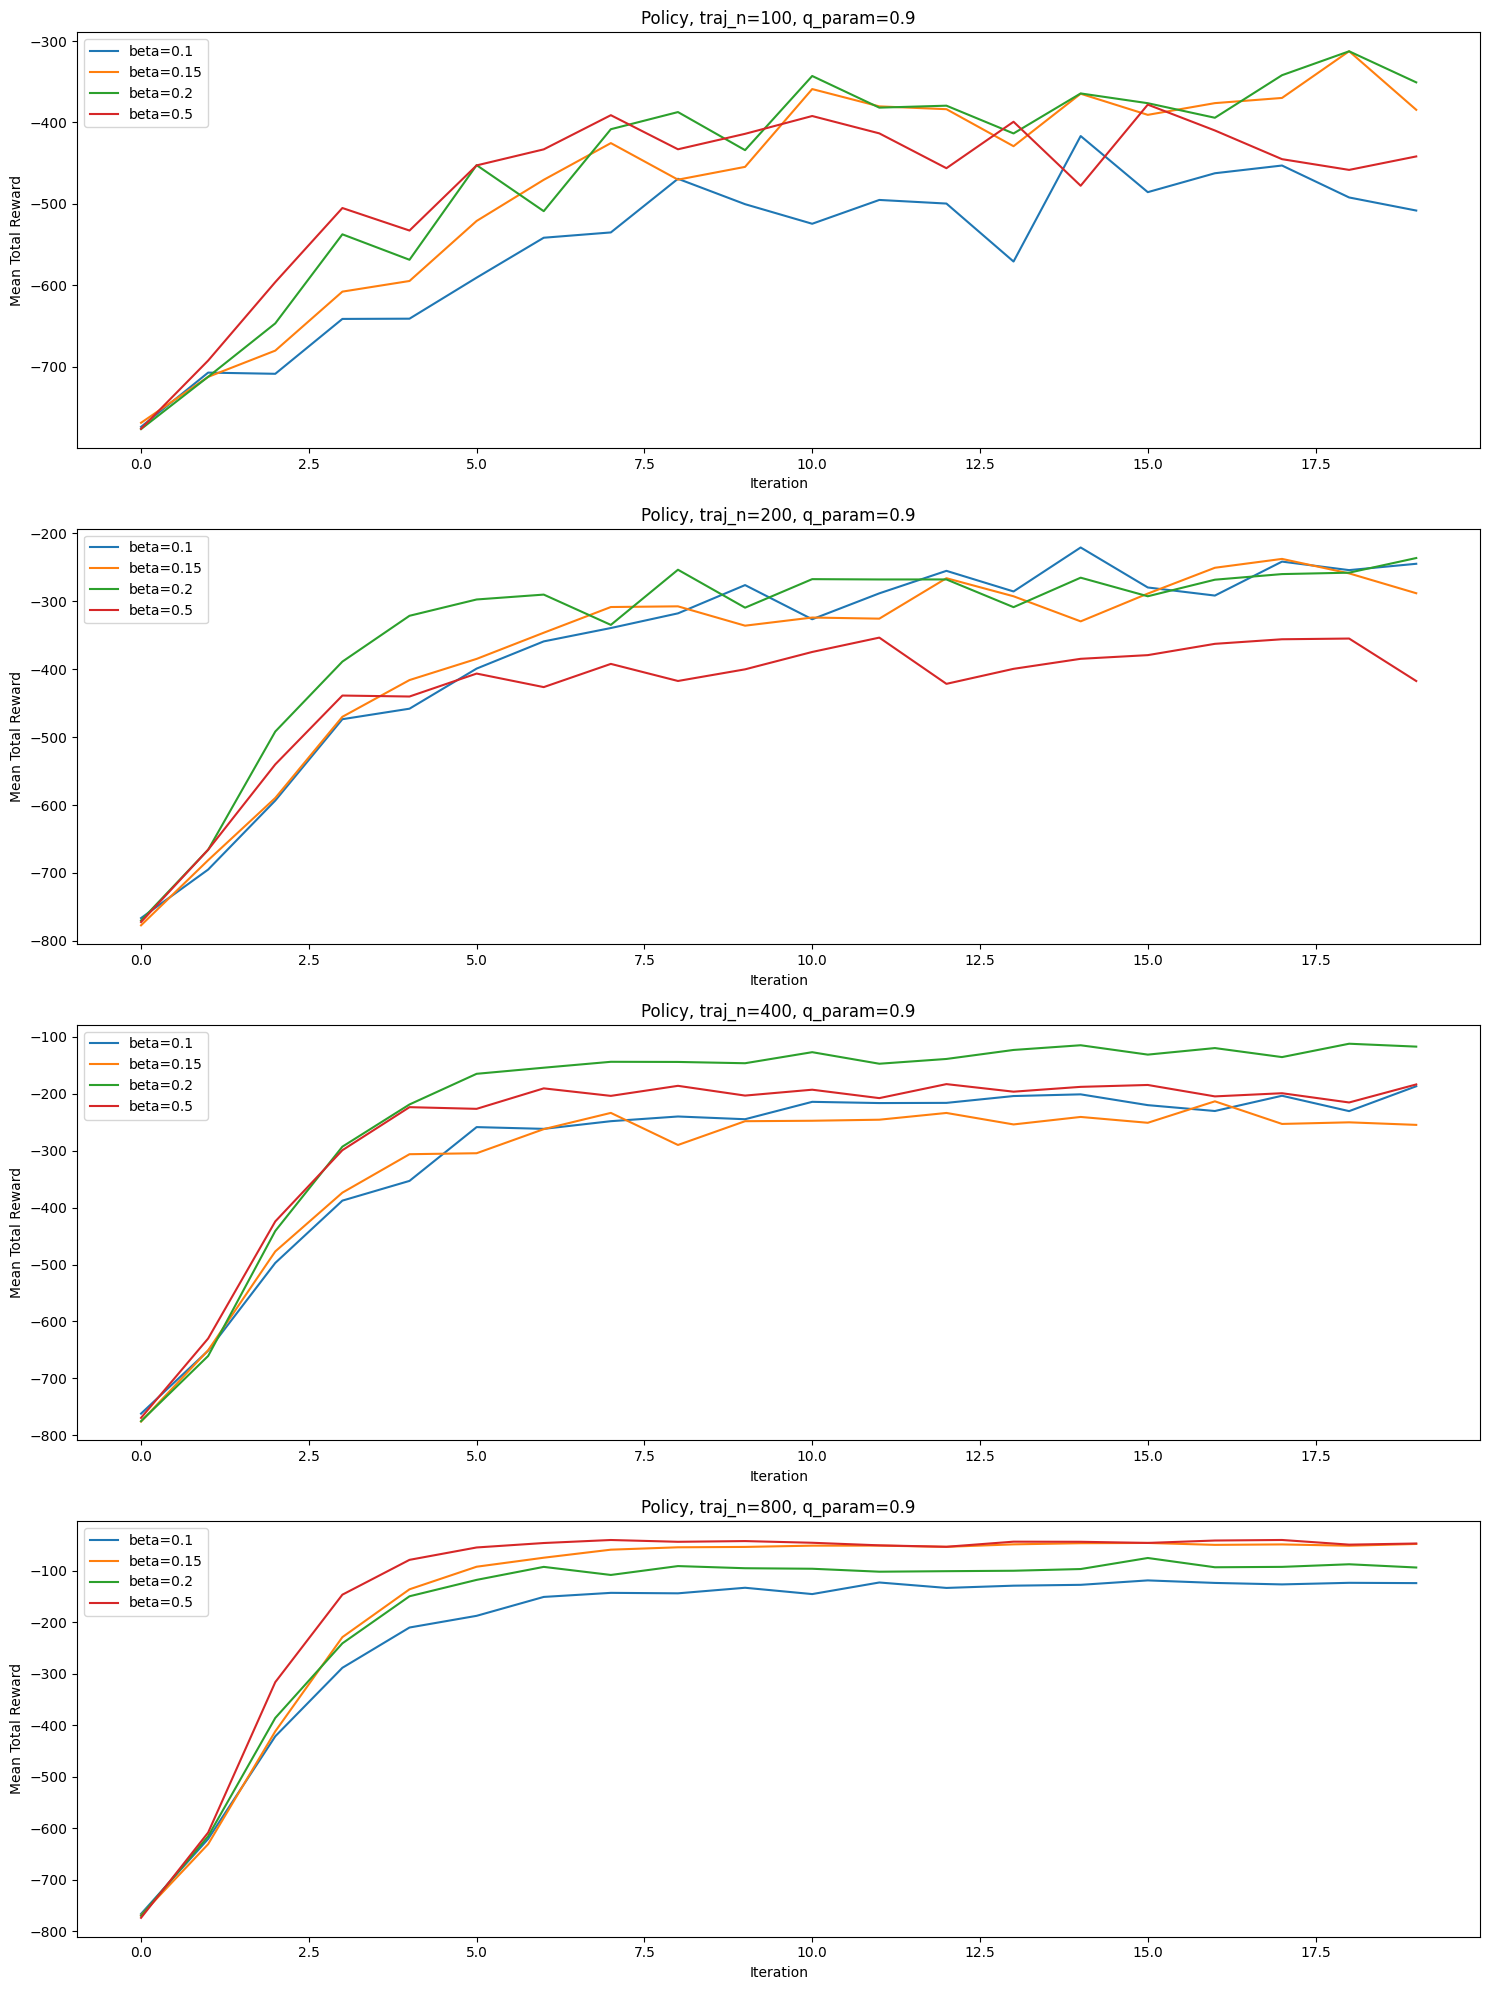

Training configurations: 100%|██████████| 3/3 [25:03<00:00, 501.12s/it]


In [26]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

class CrossEntropyAgent:
    def __init__(self, state_n, action_n, smoothing=None, alpha=0.01, beta=0.1):
        self.state_n = state_n
        self.action_n = action_n
        self.smoothing = smoothing
        self.alpha = alpha  # Laplace smoothing constant
        self.beta = beta    # Policy smoothing factor
        self.model = np.ones((state_n, action_n)) / action_n

    def get_action(self, state):
        probs = self.model[state]
        action = np.random.choice(self.action_n, p=probs)
        return action

    def fit(self, elite_trajectories):
        new_model = np.zeros_like(self.model)
        for trajectory in elite_trajectories:
            for state, action in zip(trajectory['states'], trajectory['actions']):
                new_model[state, action] += 1

        for state in range(self.state_n):
            if self.smoothing == "laplace":
                new_model[state] = ((new_model[state] + self.alpha) / (np.sum(new_model[state]) + self.action_n*self.alpha))
            elif self.smoothing == "policy":
                new_model[state] = (new_model[state]*self.beta + (1-self.beta)*self.model[state])
                new_model[state] /= np.sum(new_model[state])
            else:
                if np.sum(new_model[state]) > 0:
                    new_model[state] /= np.sum(new_model[state])
                else:
                    new_model[state] = self.model[state].copy()

        self.model = new_model
        return None

def get_trajectory(env, agent, max_len=1000):
    trajectory = {'states': [], 'actions': [], 'rewards': []}
    state = env.reset()
    for _ in range(max_len):
        action = agent.get_action(state)
        next_state, reward, done, _ = env.step(action)
        trajectory['states'].append(state)
        trajectory['actions'].append(action)
        trajectory['rewards'].append(reward)
        state = next_state
        if done:
            break
    return trajectory

def train_agent(agent, iteration_n, trajectory_n, q_param_values):
    results = {q_param: [] for q_param in q_param_values}

    for q_param in q_param_values:
        mean_total_rewards = []

        for iteration in range(iteration_n):
            trajectories = [get_trajectory(env, agent) for _ in range(trajectory_n)]
            total_rewards = [np.sum(trajectory['rewards']) for trajectory in trajectories]

            quantile = np.quantile(total_rewards, q_param)
            elite_trajectories = [trajectory for trajectory in trajectories if np.sum(trajectory['rewards']) >= quantile]

            agent.fit(elite_trajectories)
            mean_total_rewards.append(np.mean(total_rewards))

        results[q_param] = mean_total_rewards

    return results

iteration_n = 20
q_param_values = [0.75, 0.8, 0.85, 0.9]

# Configurations
configs = {
    'Standard': {'trajectory_ns': [100, 200, 400, 800, 1600], 'smoothing': None},
    'Laplace': {'trajectory_ns': [100, 200, 400, 800], 'smoothing': 'laplace', 'alphas': [0.001, 0.01, 0.03, 0.08]},
    'Policy': {'trajectory_ns': [100, 200, 400, 800], 'smoothing': 'policy', 'betas': [0.1, 0.15, 0.2, 0.5]}
}

env = gym.make('Taxi-v3')
state_n = env.observation_space.n
action_n = env.action_space.n

for config_name, config in tqdm(configs.items(), desc='Training configurations'):
    for q_param in q_param_values:
        fig, axs = plt.subplots(len(config['trajectory_ns']), figsize=(15, 20))
        axs = axs.ravel()

        for j, trajectory_n in enumerate(config['trajectory_ns']):
            if 'alphas' in config:
                for alpha in config['alphas']:
                    agent = CrossEntropyAgent(state_n, action_n, smoothing=config['smoothing'], alpha=alpha)
                    results = train_agent(agent, iteration_n, trajectory_n, [q_param])
                    axs[j].plot(results[q_param], label=f'alpha={alpha}')
            elif 'betas' in config:
                for beta in config['betas']:
                    agent = CrossEntropyAgent(state_n, action_n, smoothing=config['smoothing'], beta=beta)
                    results = train_agent(agent, iteration_n, trajectory_n, [q_param])
                    axs[j].plot(results[q_param], label=f'beta={beta}')
            else:
                agent = CrossEntropyAgent(state_n, action_n, smoothing=config['smoothing'])
                results = train_agent(agent, iteration_n, trajectory_n, [q_param])
                axs[j].plot(results[q_param], label="No Smoothing")

            axs[j].set_title(f'{config_name}, traj_n={trajectory_n}, q_param={q_param}')
            axs[j].set_xlabel('Iteration')
            axs[j].set_ylabel('Mean Total Reward')
            axs[j].legend()

        plt.tight_layout()
        plt.show()

Training configurations:   0%|          | 0/3 [00:00<?, ?it/s]

Standard


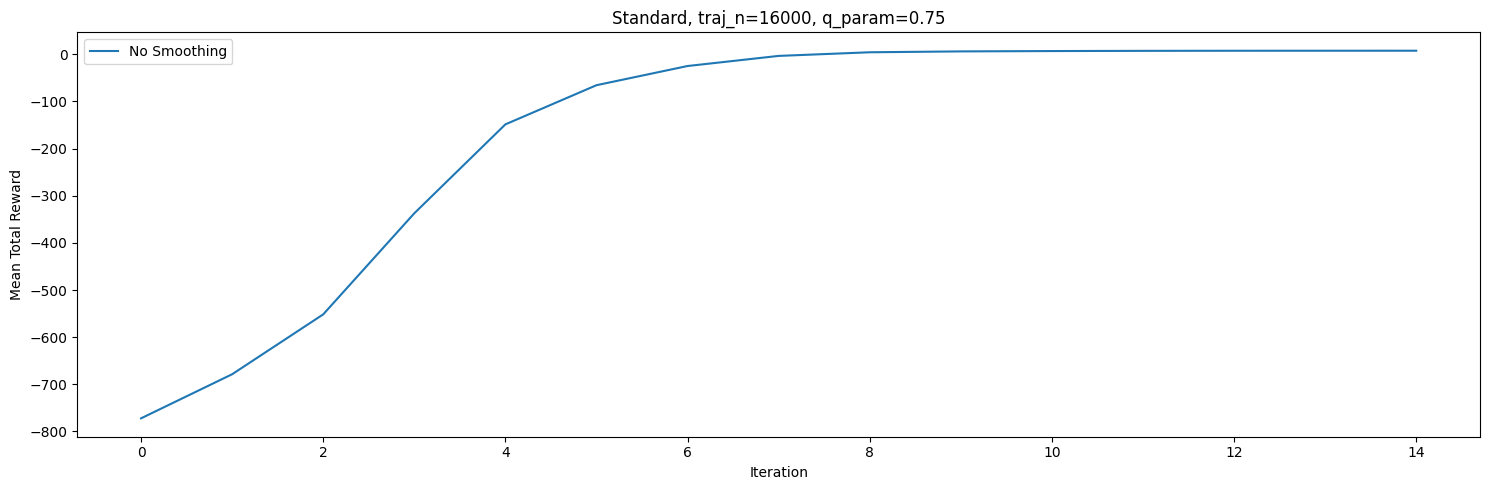

Standard


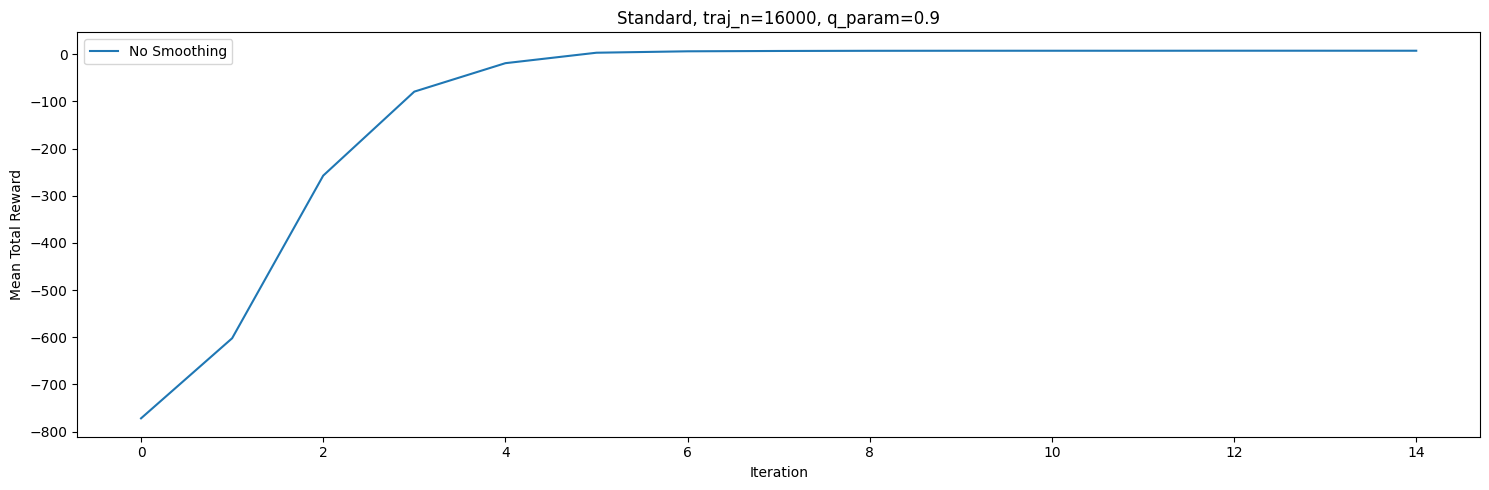

Standard


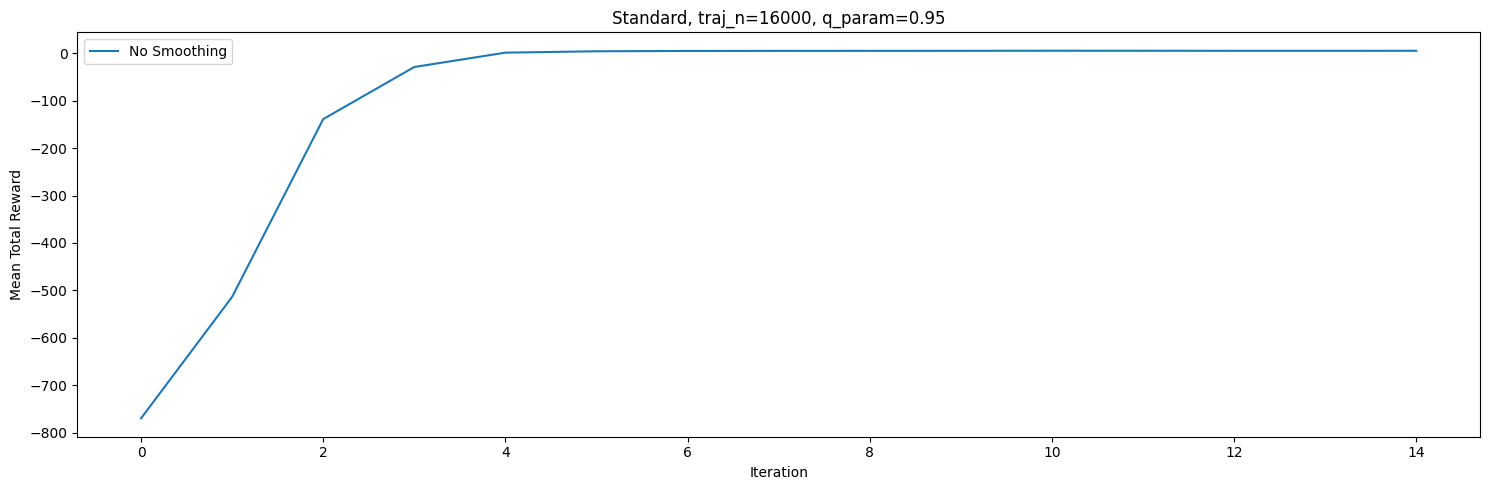

Training configurations:  33%|███▎      | 1/3 [09:17<18:35, 557.90s/it]

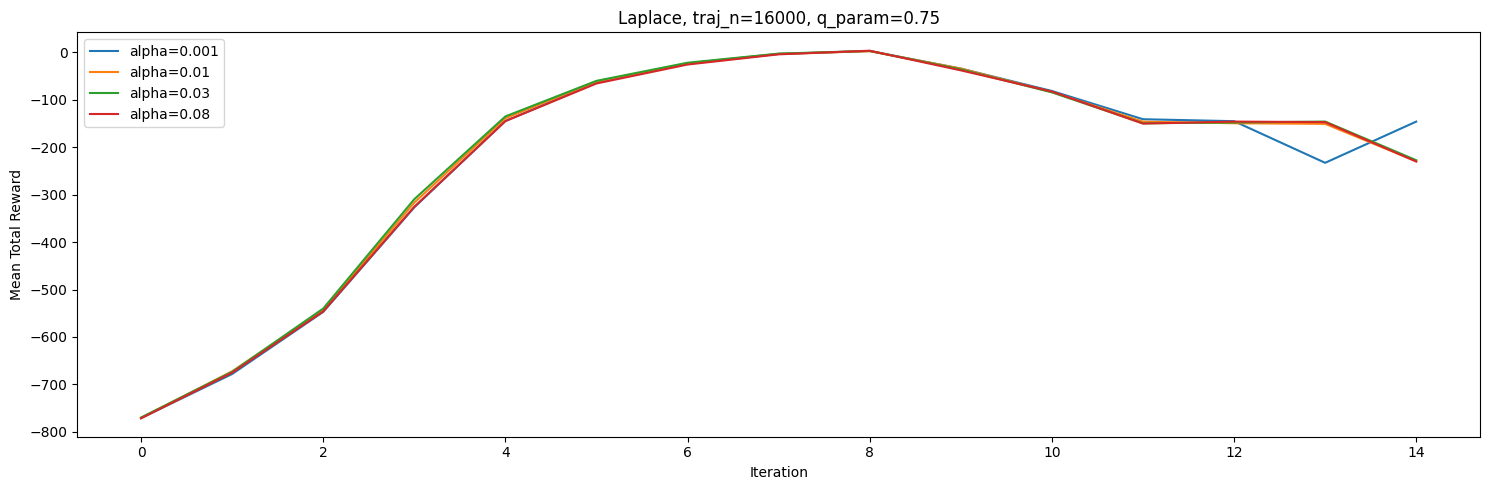

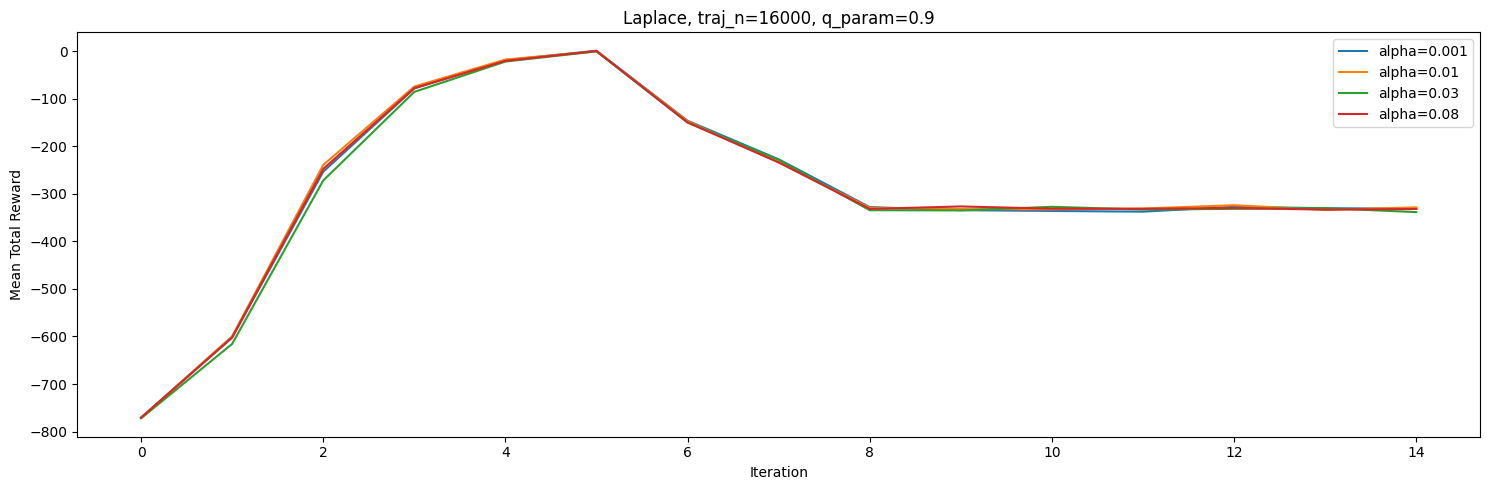

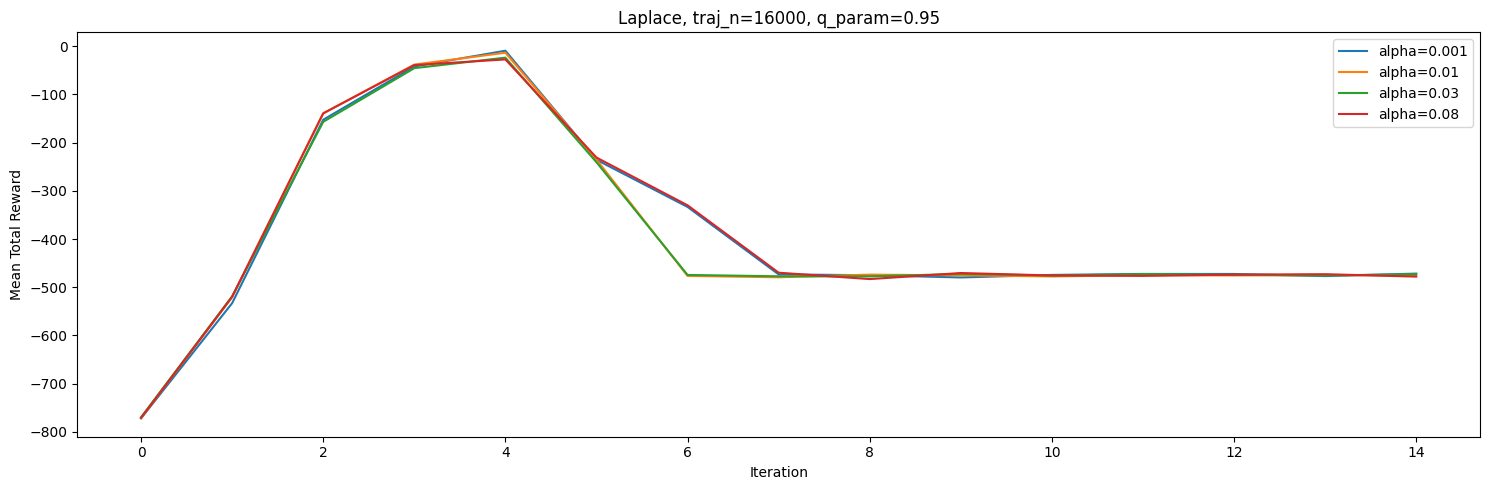

Training configurations:  67%|██████▋   | 2/3 [1:14:54<42:25, 2545.32s/it]

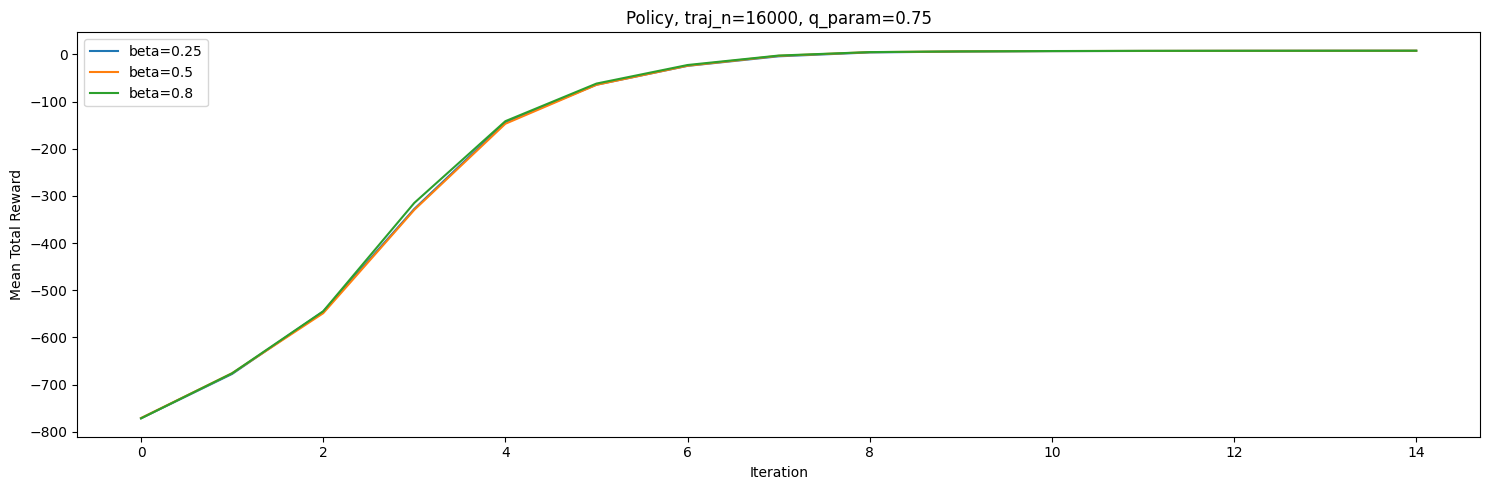

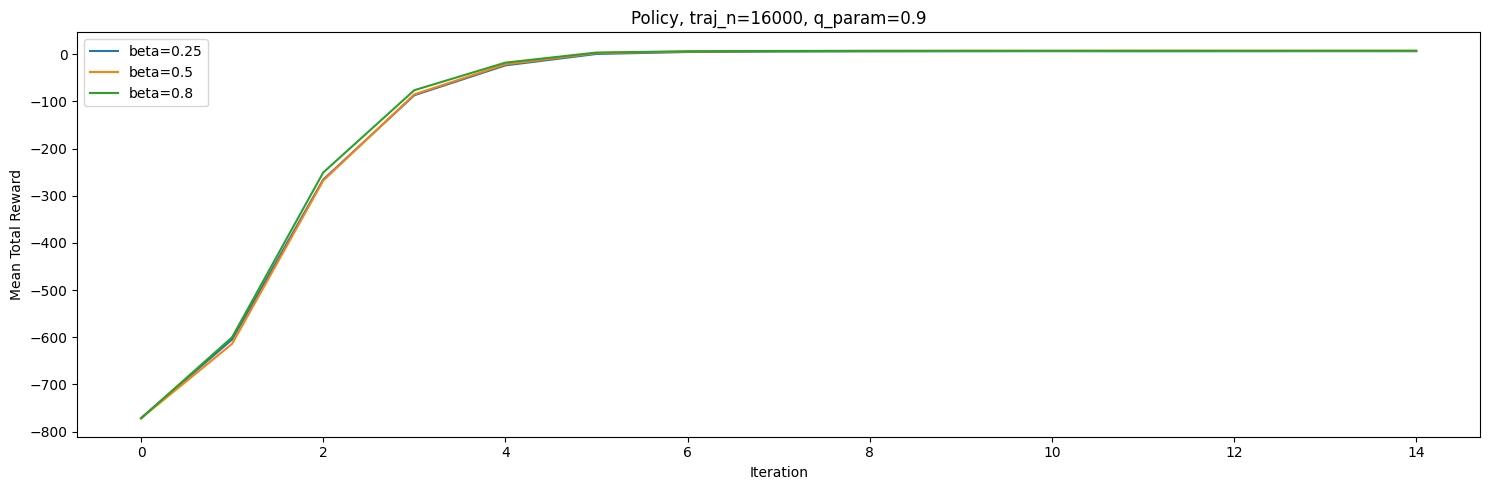

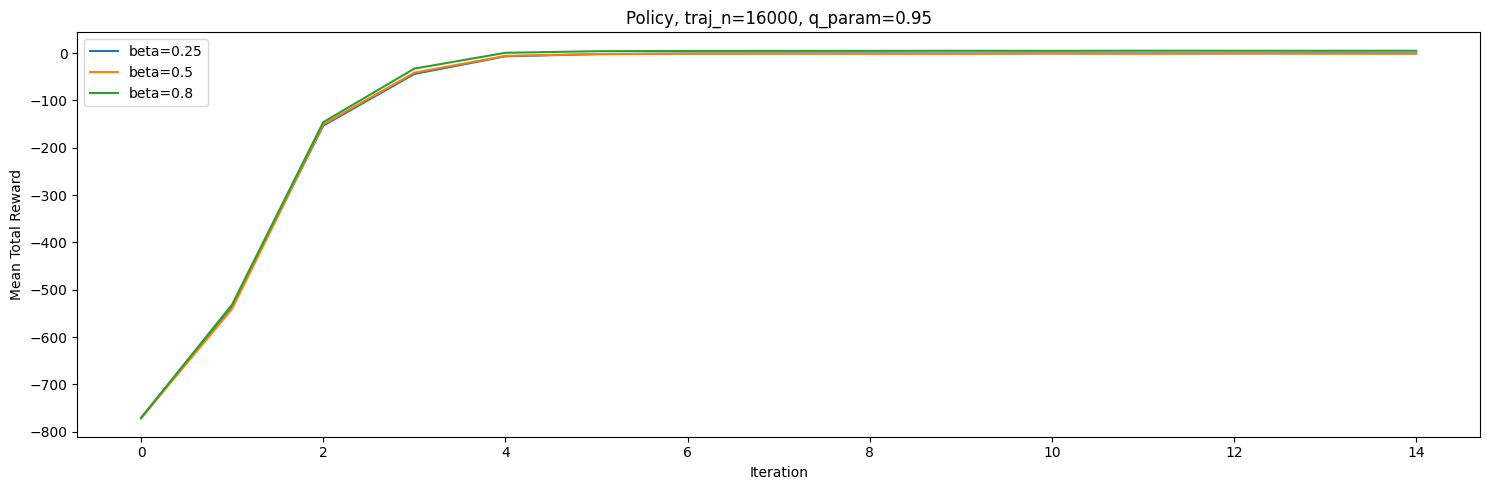

Training configurations: 100%|██████████| 3/3 [1:41:34<00:00, 2031.36s/it]


In [30]:
def train_agent(agent, iteration_n, trajectory_n, q_param_values):
    results = {}

    for q_param in q_param_values:
        mean_total_rewards = []

        for iteration in range(iteration_n):
            trajectories = [get_trajectory(env, agent) for _ in range(trajectory_n)]
            total_rewards = [np.sum(trajectory['rewards']) for trajectory in trajectories]

            quantile = np.quantile(total_rewards, q_param)
            elite_trajectories = [trajectory for trajectory in trajectories if np.sum(trajectory['rewards']) >= quantile]

            agent.fit(elite_trajectories)
            mean_total_rewards.append(np.mean(total_rewards))

        results[q_param] = mean_total_rewards

    return results

iteration_n = 15
q_param_values = [0.75, 0.9, 0.95]

# Configurations
configs = {
    'Standard': {'trajectory_ns': [16000], 'smoothing': None},
    'Laplace': {'trajectory_ns': [16000], 'smoothing': 'laplace', 'alphas': [0.001, 0.01, 0.03, 0.08]},
    'Policy': {'trajectory_ns': [16000], 'smoothing': 'policy', 'betas': [0.25, 0.5, 0.8]}
}

env = gym.make('Taxi-v3')
state_n = env.observation_space.n
action_n = env.action_space.n

for config_name, config in tqdm(configs.items(), desc='Training configurations'):
    for q_param in q_param_values:
        for j, trajectory_n in enumerate(config['trajectory_ns']):
            fig, axs = plt.subplots(1, figsize=(15, 5))

            if 'alphas' in config:
                for alpha in config['alphas']:
                    agent = CrossEntropyAgent(state_n, action_n, smoothing=config['smoothing'], alpha=alpha)
                    results = train_agent(agent, iteration_n, trajectory_n, [q_param])
                    axs.plot(results[q_param], label=f'alpha={alpha}')
            elif 'betas' in config:
                for beta in config['betas']:
                    agent = CrossEntropyAgent(state_n, action_n, smoothing=config['smoothing'], beta=beta)
                    results = train_agent(agent, iteration_n, trajectory_n, [q_param])
                    axs.plot(results[q_param], label=f'beta={beta}')
            else:
                print(config_name)
                agent = CrossEntropyAgent(state_n, action_n, smoothing=config['smoothing'])
                results = train_agent(agent, iteration_n, trajectory_n, [q_param])
                axs.plot(results[q_param], label="No Smoothing")

            axs.set_title(f'{config_name}, traj_n={trajectory_n}, q_param={q_param}')
            axs.set_xlabel('Iteration')
            axs.set_ylabel('Mean Total Reward')
            axs.legend()

            plt.tight_layout()
            plt.show()

Training configurations:   0%|          | 0/3 [00:00<?, ?it/s]

Standard


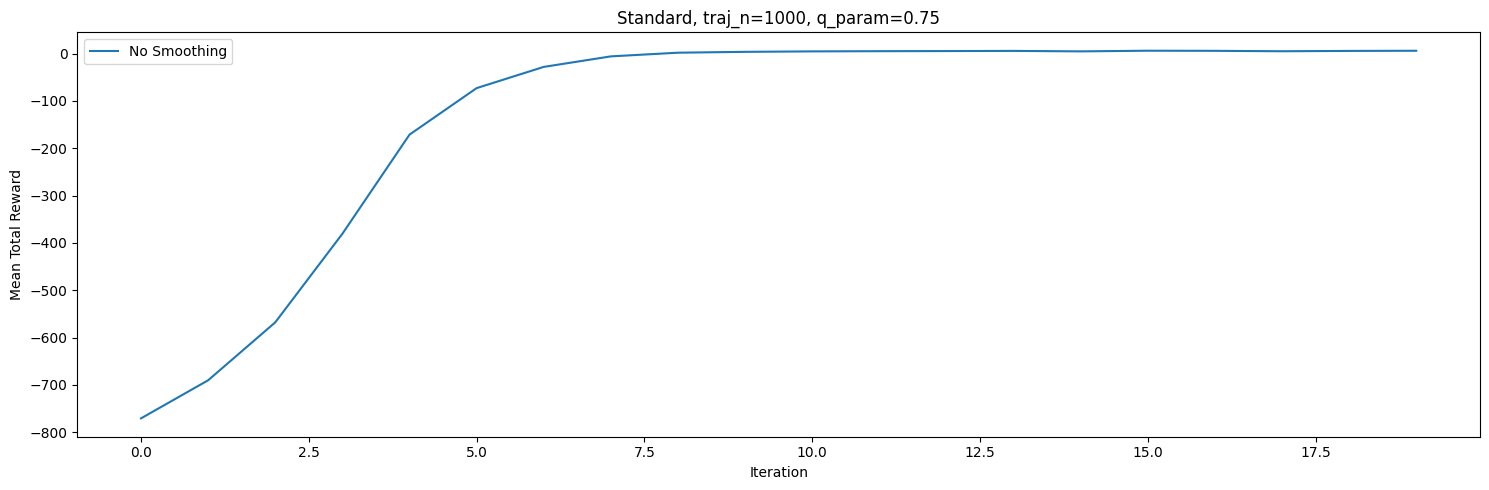

Standard


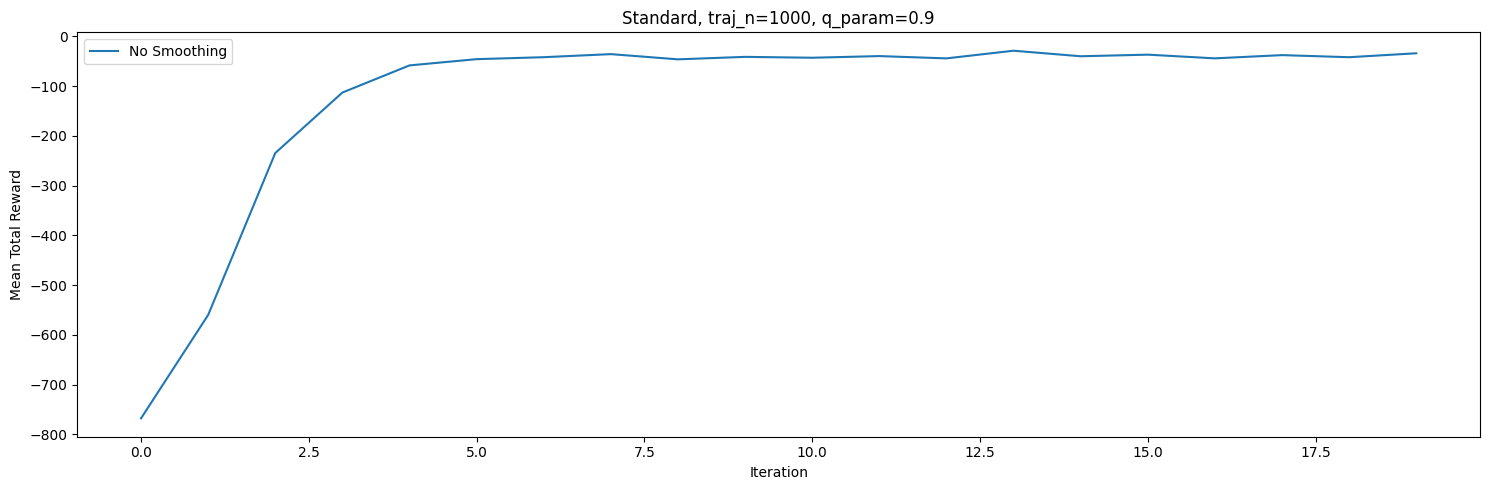

Standard


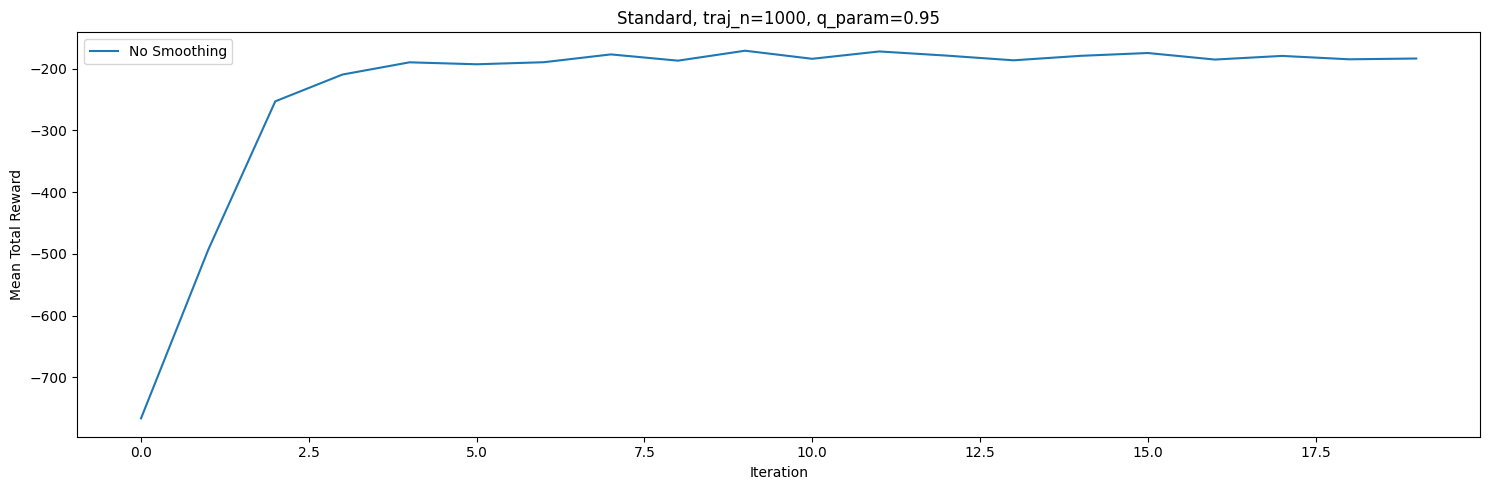

Training configurations:  33%|███▎      | 1/3 [00:54<01:49, 54.79s/it]

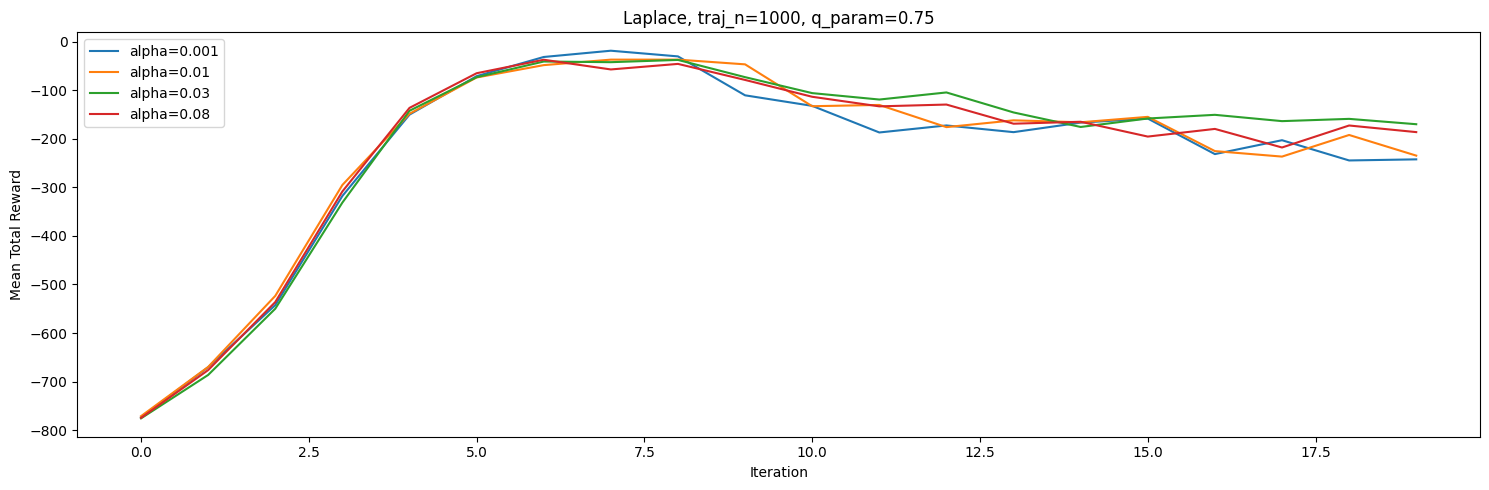

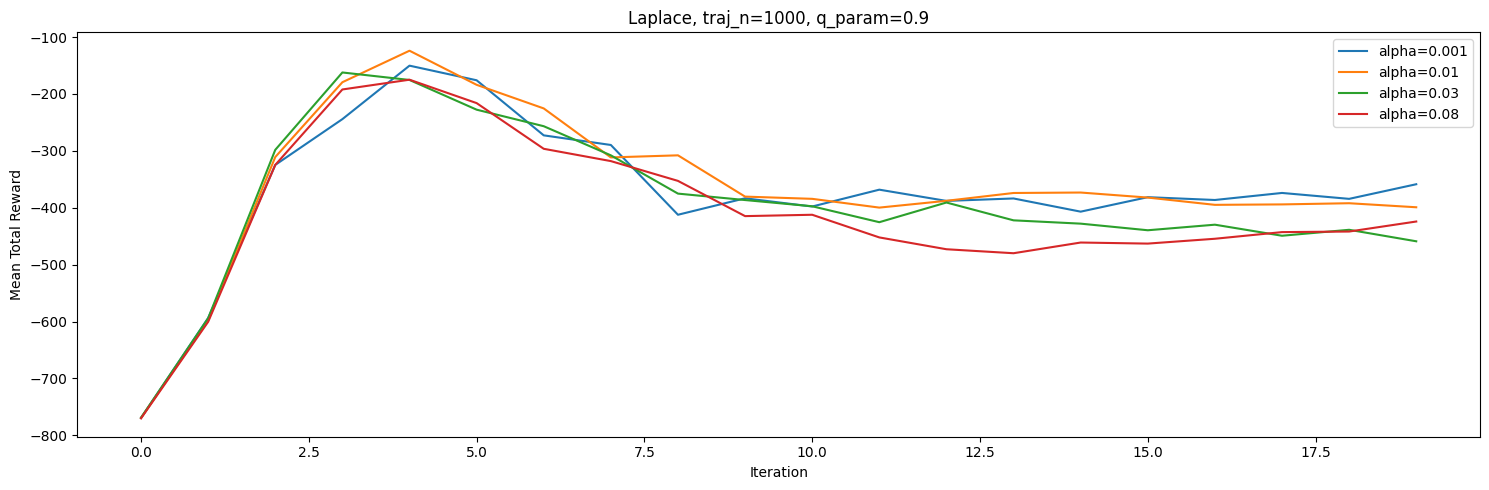

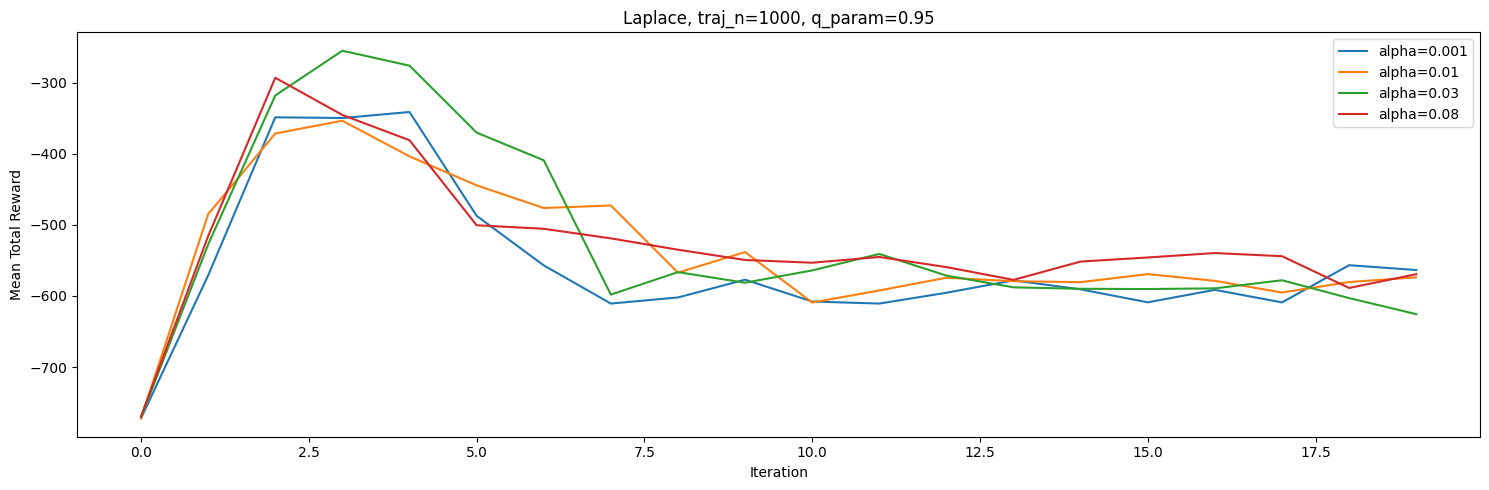

Training configurations:  67%|██████▋   | 2/3 [07:29<04:14, 254.52s/it]

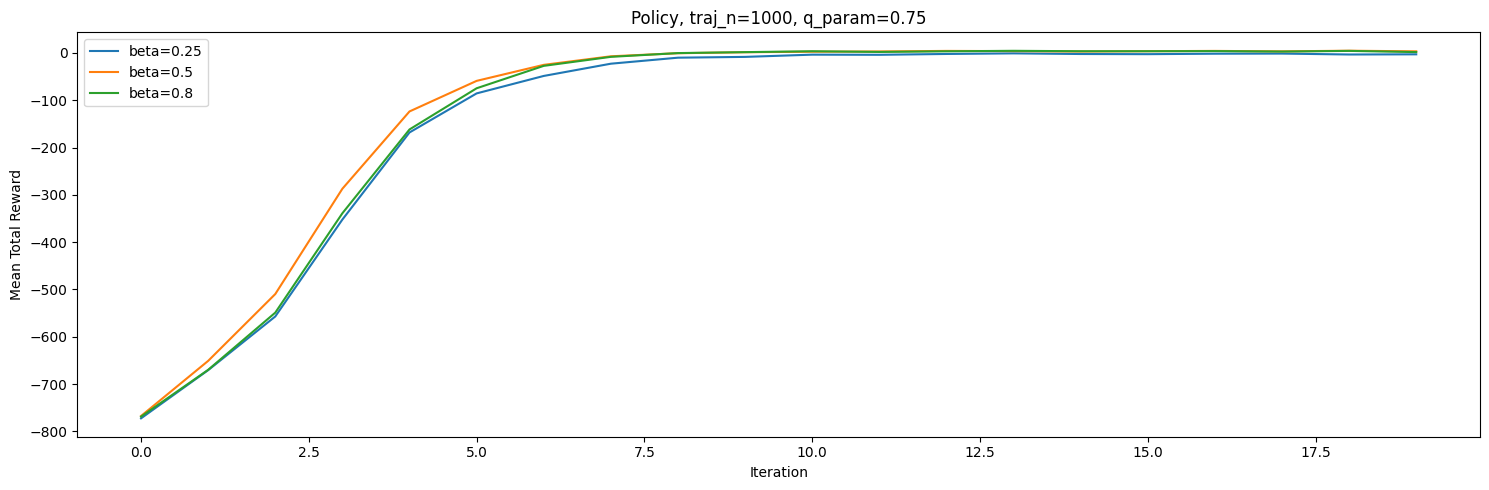

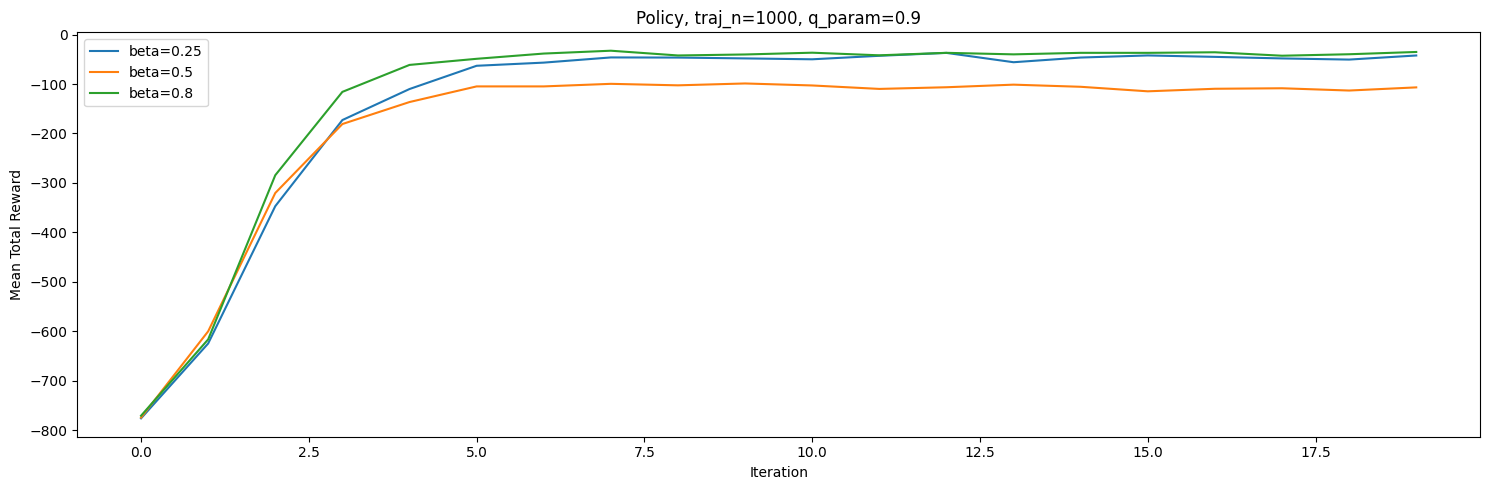

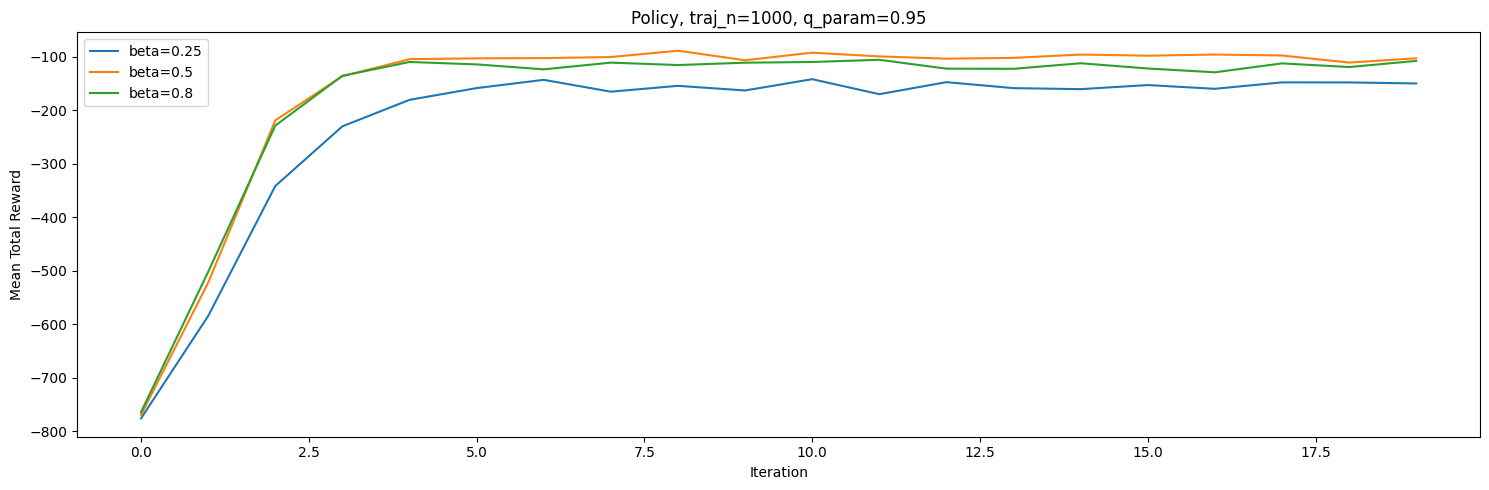

Training configurations: 100%|██████████| 3/3 [10:07<00:00, 202.58s/it]


In [31]:
iteration_n = 20
q_param_values = [0.75, 0.9, 0.95]

# Configurations
configs = {
    'Standard': {'trajectory_ns': [1000], 'smoothing': None},
    'Laplace': {'trajectory_ns': [1000], 'smoothing': 'laplace', 'alphas': [0.001, 0.01, 0.03, 0.08]},
    'Policy': {'trajectory_ns': [1000], 'smoothing': 'policy', 'betas': [0.25, 0.5, 0.8]}
}

env = gym.make('Taxi-v3')
state_n = env.observation_space.n
action_n = env.action_space.n

for config_name, config in tqdm(configs.items(), desc='Training configurations'):
    for q_param in q_param_values:
        for j, trajectory_n in enumerate(config['trajectory_ns']):
            fig, axs = plt.subplots(1, figsize=(15, 5))

            if 'alphas' in config:
                for alpha in config['alphas']:
                    agent = CrossEntropyAgent(state_n, action_n, smoothing=config['smoothing'], alpha=alpha)
                    results = train_agent(agent, iteration_n, trajectory_n, [q_param])
                    axs.plot(results[q_param], label=f'alpha={alpha}')
            elif 'betas' in config:
                for beta in config['betas']:
                    agent = CrossEntropyAgent(state_n, action_n, smoothing=config['smoothing'], beta=beta)
                    results = train_agent(agent, iteration_n, trajectory_n, [q_param])
                    axs.plot(results[q_param], label=f'beta={beta}')
            else:
                print(config_name)
                agent = CrossEntropyAgent(state_n, action_n, smoothing=config['smoothing'])
                results = train_agent(agent, iteration_n, trajectory_n, [q_param])
                axs.plot(results[q_param], label="No Smoothing")

            axs.set_title(f'{config_name}, traj_n={trajectory_n}, q_param={q_param}')
            axs.set_xlabel('Iteration')
            axs.set_ylabel('Mean Total Reward')
            axs.legend()

            plt.tight_layout()
            plt.show()